# 📊 Feature Explanation – IEEE-CIS Fraud Detection

## 1. Transaction Features
- **TransactionID**: Unique identifier for each transaction. Used to merge with the identity table, not directly useful for modeling.  
- **TransactionDT**: Time in seconds from a reference point (not a real timestamp).
- **TransactionAmt**: Transaction amount. Fraud often involves:  
  - Very small amounts (testing stolen cards).  
  - Very large amounts (cash-out quickly).  
- **ProductCD**: Product category (e.g., W, C, H, R, S).  

---

## 2. Card Features (card1–card6)
- **card1**: User/account identifier (anonymized).
- **card2**: Issuing bank (anonymized).  
- **card3**: Country of issuing bank.  
- **card4**: Card type (Visa, MasterCard, Amex, etc.).  
- **card5**: Card series number.  
- **card6**: Card category (credit/debit).    

---

## 3. Address Features
- **addr1**: Billing region.  
- **addr2**: Billing country.  

---

## 4. Email Features
- **P_emaildomain**: Purchaser’s email domain.  
- **R_emaildomain**: Recipient’s email domain.  

---

## 5. Counting Features (C1–C14)
- Pre-engineered **count statistics** (anonymized).  
- Example meaning: number of transactions linked to a card or user.  

---

## 6. Time Delta Features (D1–D15)
- Pre-engineered **time-related deltas**.  
- Examples:  
  - `D1` ≈ days since first transaction of user.  
  - `D10` ≈ days since last billing.  

---

## 7. Matching Features (M1–M9)
- Boolean flags (Yes/No/NaN).  
- Indicate whether information matches across sources (e.g., billing vs. shipping address, email vs. card info).  

---

## 8. Engineered Features (V1–V339)
- Large set of anonymized engineered features.  
- Likely derived from C/D/M variables via normalization, statistical transformations, or PCA.  


---

## 9. Identity Features
- **DeviceType**: Desktop or mobile.  
- **DeviceInfo**: OS/browser/device information.  
- **id_01–id_38**: Digital identity flags (proxy usage, cookies, authentication methods, risk scores).  

---

## ✅ Summary
- **Transaction-related features**: core info (time, amount, product).  
- **Card/Address/Email**: user identifiers, useful for grouping & mismatch detection.  
- **C, D, M features**: pre-computed stats on frequency, time deltas, matches.  
- **V features**: anonymized engineered variables.  
- **Identity features**: digital fingerprint of users.  

Together, these 400+ features provide rich signals for modeling fraud detection.

In [1]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler , LabelEncoder 
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

# Data Overview

In [2]:
df = pd.read_csv("data/train_merged.csv") 

In [3]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [5]:
df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

# Data Quality

In [6]:
#  mising value
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data.sort_values(by='Percentage', ascending=False)
missing_data

,Missing Values,Percentage
card2,8933,1.512683
card3,1565,0.265012
card4,1577,0.267044
card5,4259,0.721204
card6,1571,0.266028
addr1,65706,11.126427
addr2,65706,11.126427
dist1,352271,59.652352
dist2,552913,93.628374
P_emaildomain,94456,15.994852


In [7]:
#  duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_rows_count = duplicate_rows.shape[0]
duplicate_rows_count

0

# Exploration Data Analysis

## Target IsFraud

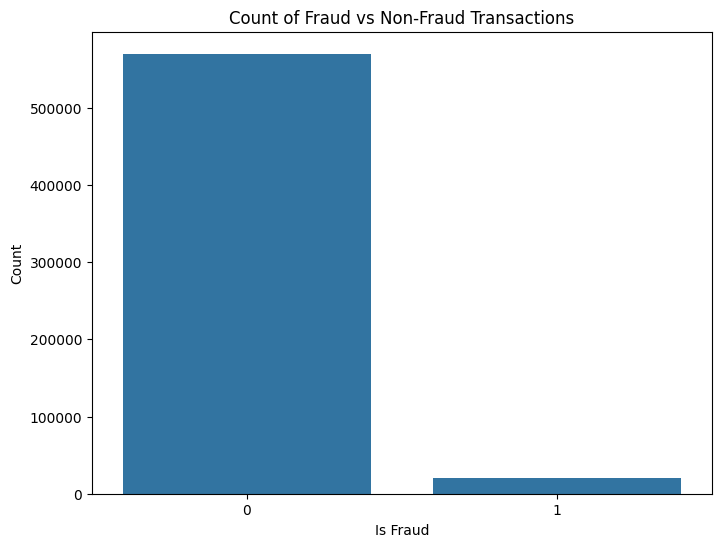

In [42]:
# count plot of target 
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Count of Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()


`Dataset is imbalanced --> need to scale` 

## Transaction Features

### TransactionDT : `Time in seconds from a reference point` 

In [8]:
# Missing value of TransactionDT 
df['TransactionDT'].isnull().sum()

np.int64(0)

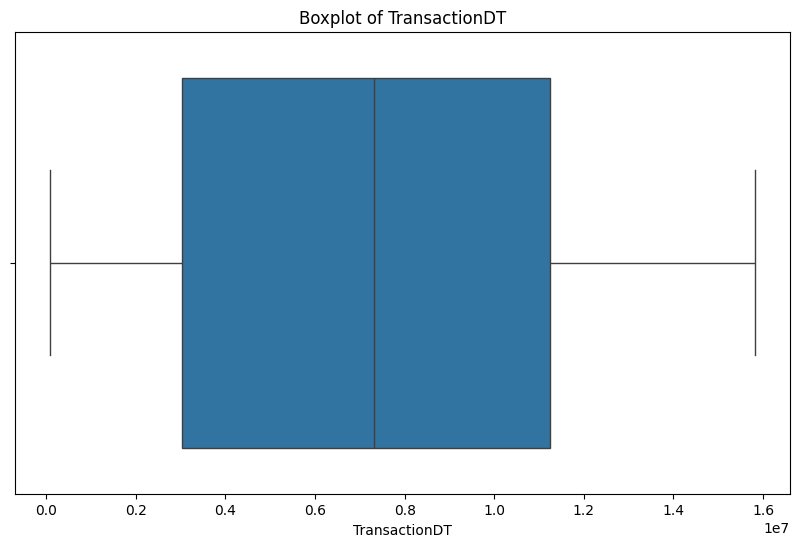

In [9]:
# boxplot of TransactionDT
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['TransactionDT'])
plt.title('Boxplot of TransactionDT')
plt.xlabel('TransactionDT')
plt.show()

In [12]:
df['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

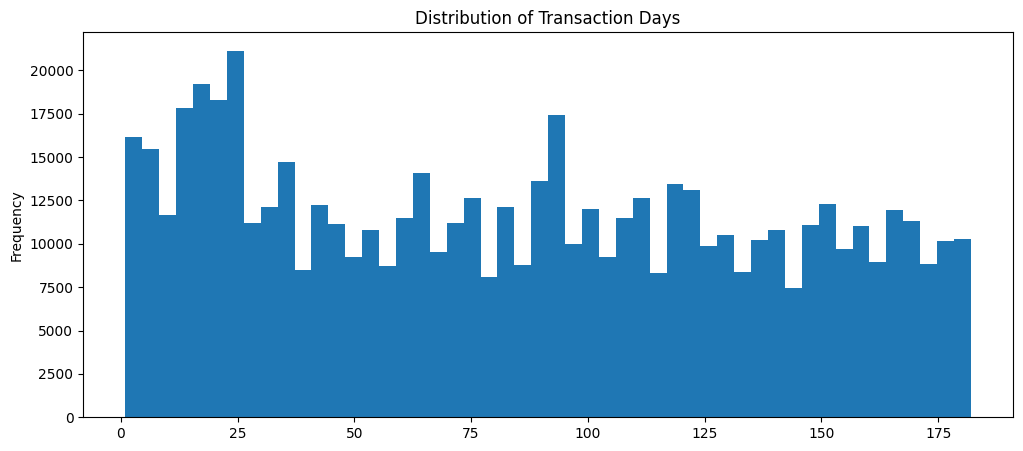

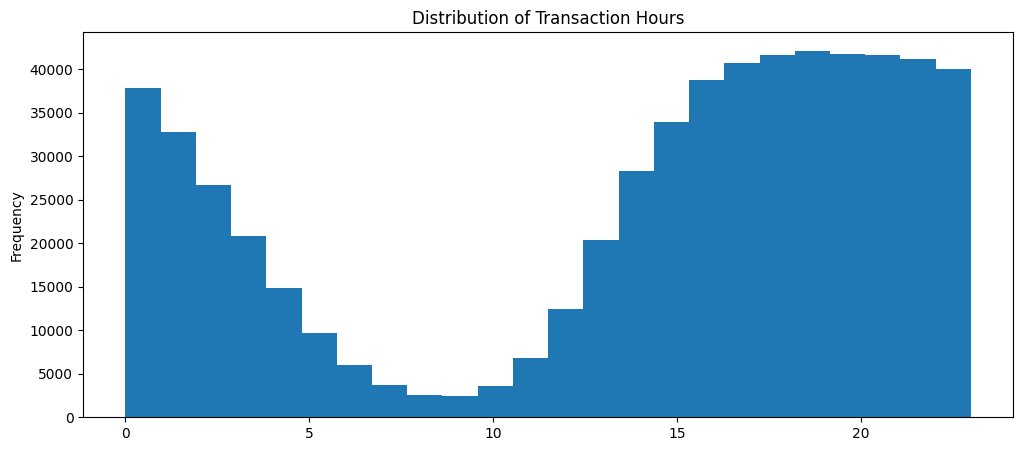

In [20]:
# Convert TransactionDT into days (approximate)
df["TransactionDay"] = df["TransactionDT"] // (24*60*60)
df["TransactionHour"] = (df["TransactionDT"] // 3600) % 24

# Plot transactions over time
plt.figure(figsize=(12,5))
df["TransactionDay"].plot(kind="hist", bins=50 , title="Distribution of Transaction Days")
plt.show()

plt.figure(figsize=(12,5))
df["TransactionHour"].plot(kind="hist", bins=24 , title="Distribution of Transaction Hours")
plt.show()

The histogram shows a clear cyclical pattern in transaction time. Instead of being uniformly distributed, transactions are concentrated in specific time ranges, creating two main peaks. This indicates that transactions tend to occur more frequently during certain periods, possibly reflecting daily user behavior (example: daytime vs nighttime activity). Such patterns could be relevant in detecting anomalies, since fraudulent transactions may not follow the same temporal distribution as legitimate ones.

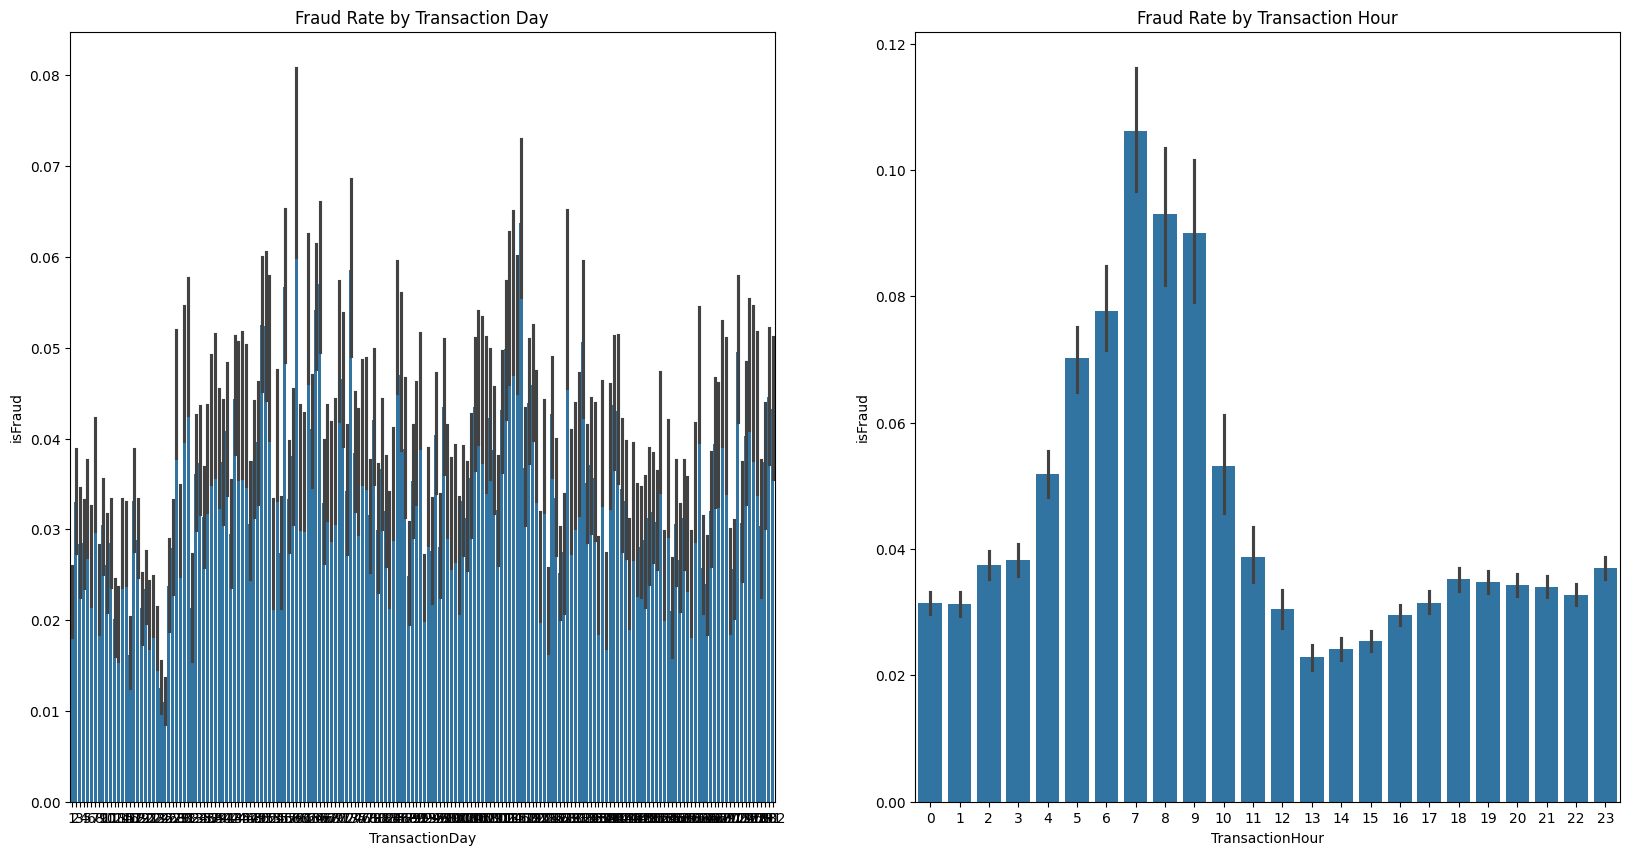

In [22]:
#  plot fraudrate vs TransactionDay  and plot fraudrate vs TransactionHour 
fig , axs = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x="TransactionDay", y="isFraud", data=df, ax=axs[0])
axs[0].set_title("Fraud Rate by Transaction Day")
sns.barplot(x="TransactionHour", y="isFraud", data=df, ax=axs[1])
axs[1].set_title("Fraud Rate by Transaction Hour")
plt.show()


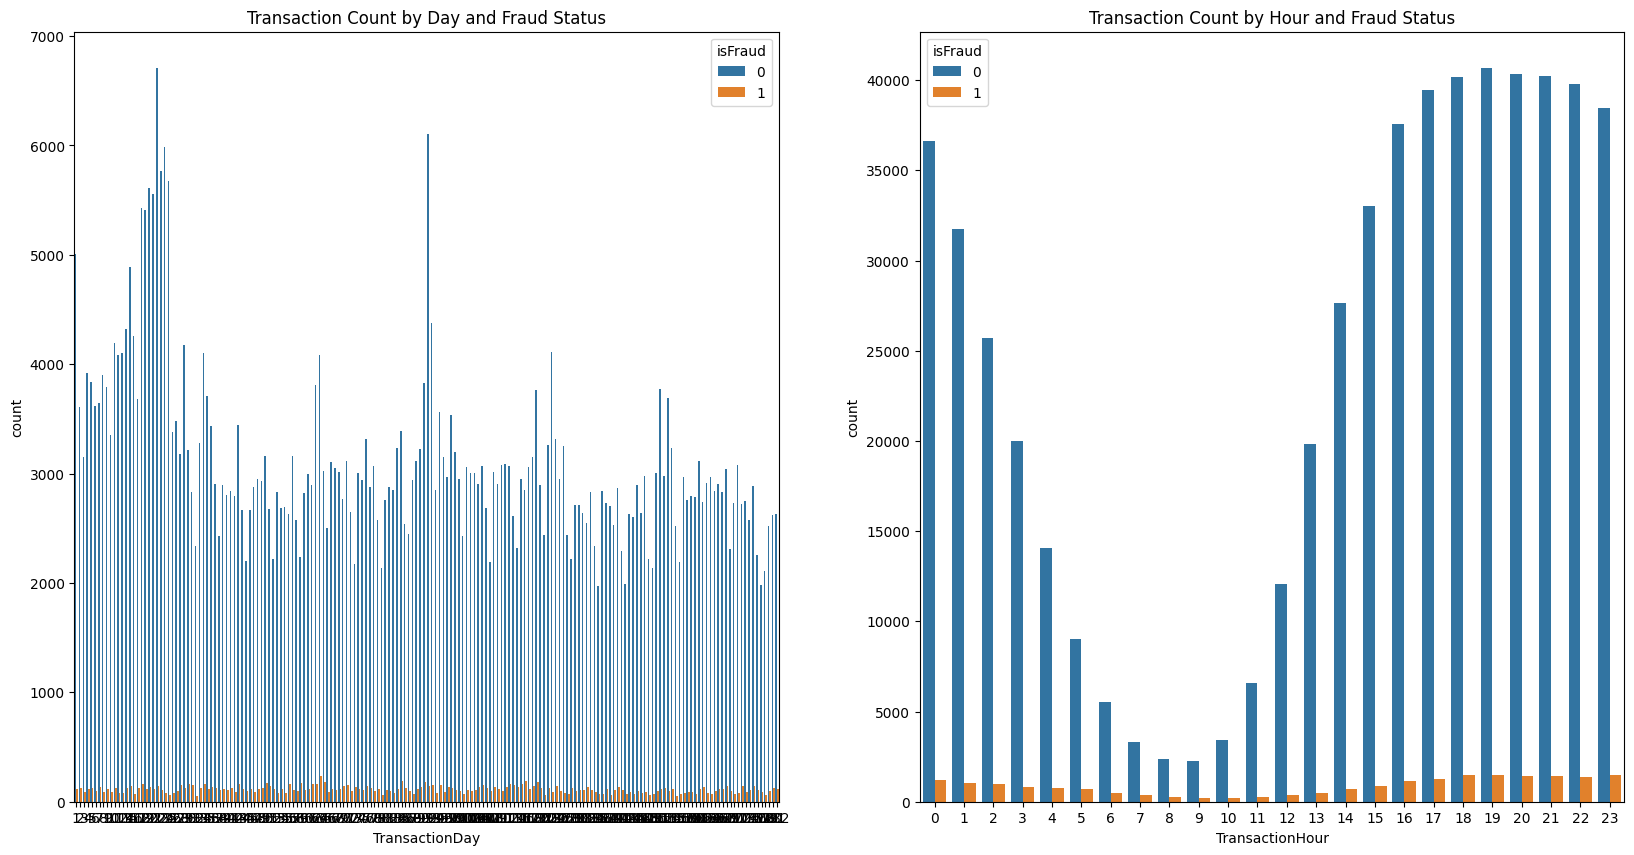

In [23]:
#  plot fraud vs TransactionDay  and plot fraud vs TransactionHour
fig , axs = plt.subplots(1,2, figsize=(20,10))
sns.countplot(x="TransactionDay", hue="isFraud", data=df, ax=axs[0])
axs[0].set_title("Transaction Count by Day and Fraud Status")
sns.countplot(x="TransactionHour", hue="isFraud", data=df, ax=axs[1])
axs[1].set_title("Transaction Count by Hour and Fraud Status")
plt.show()
 


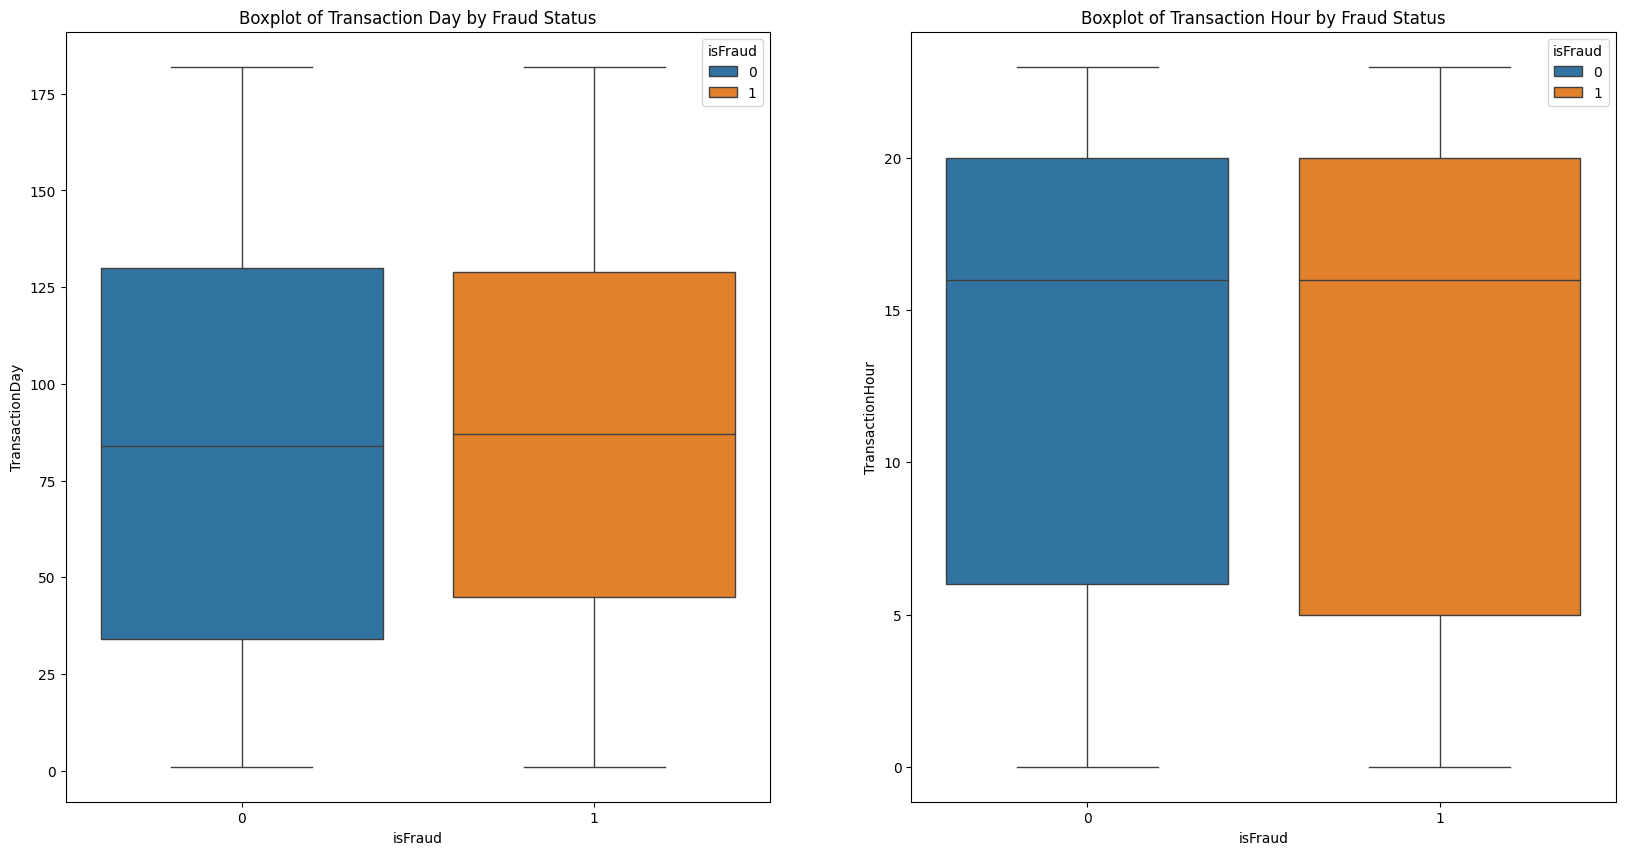

In [30]:
#  box of TransactionDay vs isFraud , box plot of TransactionHour vs isFraud 
fig , axs = plt.subplots(1,2, figsize=(20,10))
sns.boxplot(x="isFraud", y="TransactionDay", data=df, ax=axs[0] , hue="isFraud")  
axs[0].set_title("Boxplot of Transaction Day by Fraud Status")
sns.boxplot(x="isFraud", y="TransactionHour", data=df, ax=axs[1] , hue="isFraud")
axs[1].set_title("Boxplot of Transaction Hour by Fraud Status")
plt.show()



### TransactionAmt

In [31]:
# missing value of TransactionAmt
df['TransactionAmt'].isnull().sum()

np.int64(0)

In [33]:
df['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

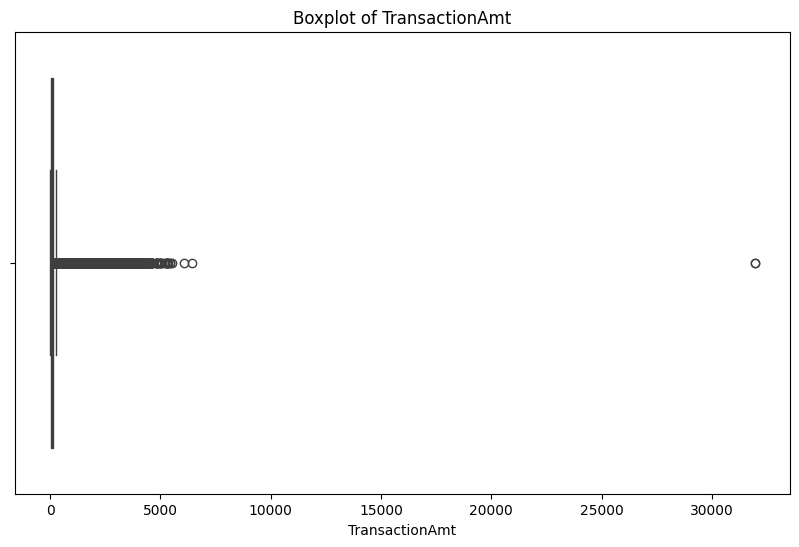

In [32]:
# boxplot of TransactionAmt
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['TransactionAmt'])
plt.title('Boxplot of TransactionAmt')
plt.xlabel('TransactionAmt')
plt.show()


Most of transaction is low amount. Many outliers which are have a TransactionAmt high 

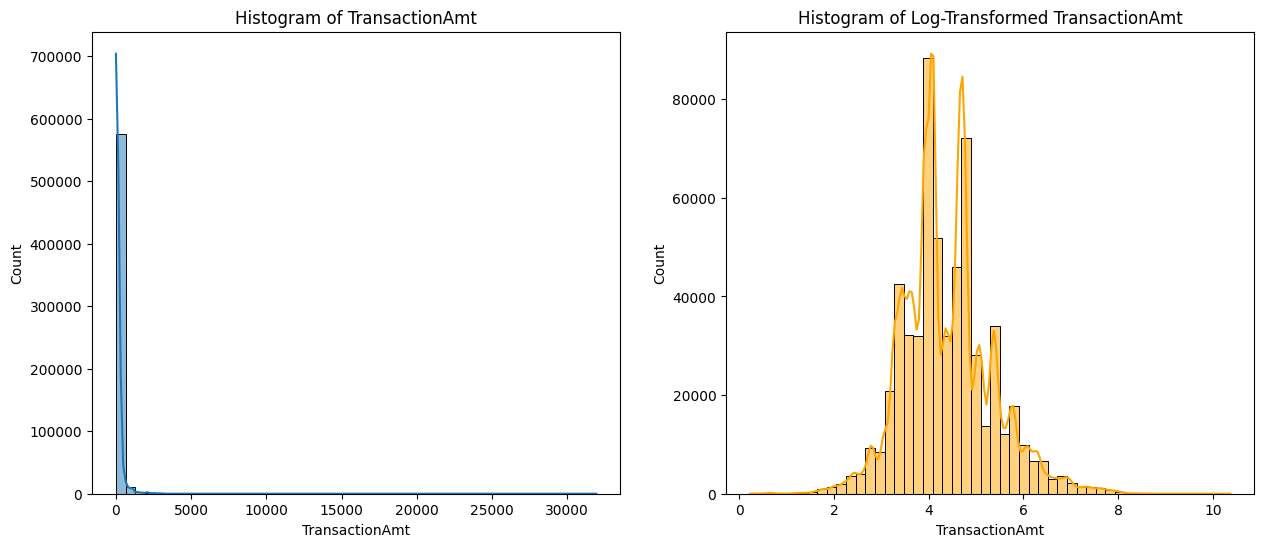

In [34]:
# Histogram of TransactionAmt and log scale
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['TransactionAmt'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of TransactionAmt')
sns.histplot(np.log1p(df['TransactionAmt']), bins=50, kde=True, ax=ax[1], color='orange')
ax[1].set_title('Histogram of Log-Transformed TransactionAmt')
plt.show()


Target Variable Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud Rate: 0.0350


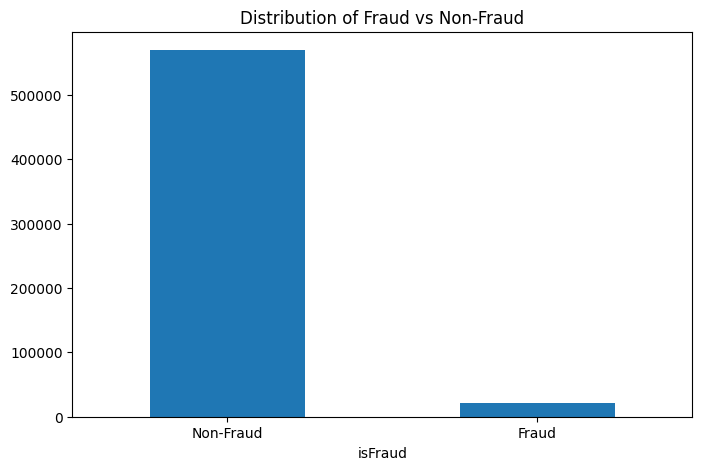

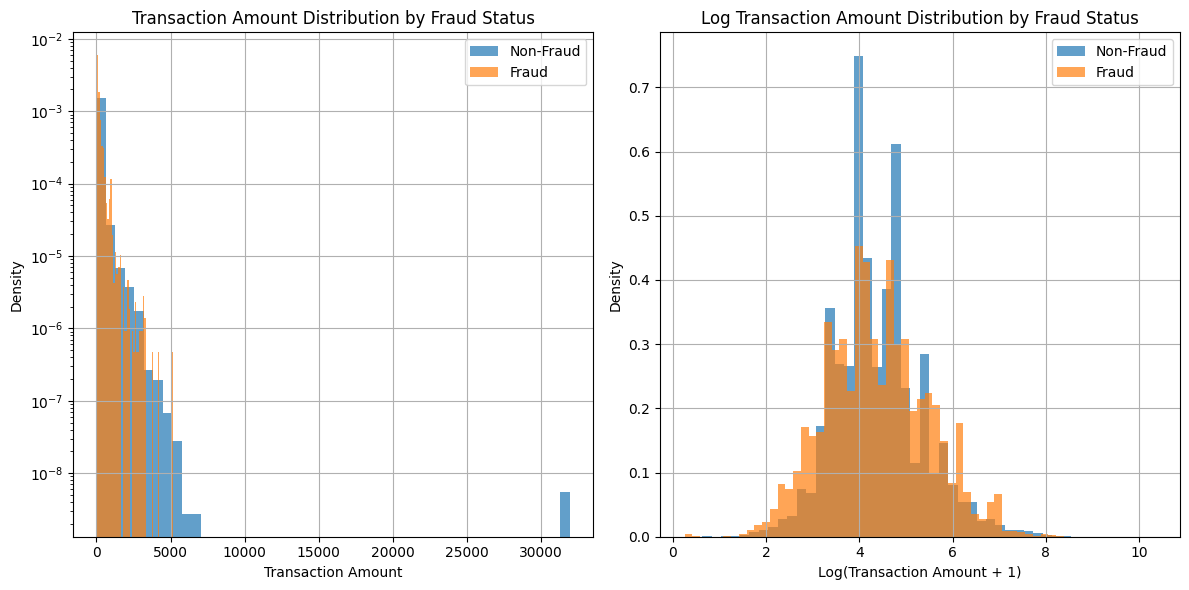


Transaction Amount Statistics by Fraud Status:
            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


In [35]:
# Transaction Features Analysis

# First, let's check the target variable distribution
print("Target Variable Distribution:")
print(df['isFraud'].value_counts())
print(f"Fraud Rate: {df['isFraud'].mean():.4f}")

plt.figure(figsize=(8,5))
df['isFraud'].value_counts().plot(kind='bar', title='Distribution of Fraud vs Non-Fraud')
plt.xticks([0,1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

# Transaction Amount vs Fraud
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df[df['isFraud']==0]['TransactionAmt'].hist(bins=50, alpha=0.7, label='Non-Fraud', density=True)
df[df['isFraud']==1]['TransactionAmt'].hist(bins=50, alpha=0.7, label='Fraud', density=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.legend()
plt.title('Transaction Amount Distribution by Fraud Status')
plt.yscale('log')

plt.subplot(1,2,2)
# Log transform for better visualization
df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
df[df['isFraud']==0]['TransactionAmt_log'].hist(bins=50, alpha=0.7, label='Non-Fraud', density=True)
df[df['isFraud']==1]['TransactionAmt_log'].hist(bins=50, alpha=0.7, label='Fraud', density=True)
plt.xlabel('Log(Transaction Amount + 1)')
plt.ylabel('Density')
plt.legend()
plt.title('Log Transaction Amount Distribution by Fraud Status')

plt.tight_layout()
plt.show()

# Statistical summary by fraud status
print("\nTransaction Amount Statistics by Fraud Status:")
print(df.groupby('isFraud')['TransactionAmt'].describe())

Most of transaction with the low amount and a little number of trans with high amount. Most of fraud is low amount 

-> `When pre-processing data can log transform, Scaling, feature engineering the Trans Amt before training model`. If not transform this column,model may be sentitive with very large amt outlier 

### ProductCD

In [40]:
# missing value of ProductCD
df['ProductCD'].isnull().sum()


np.int64(0)

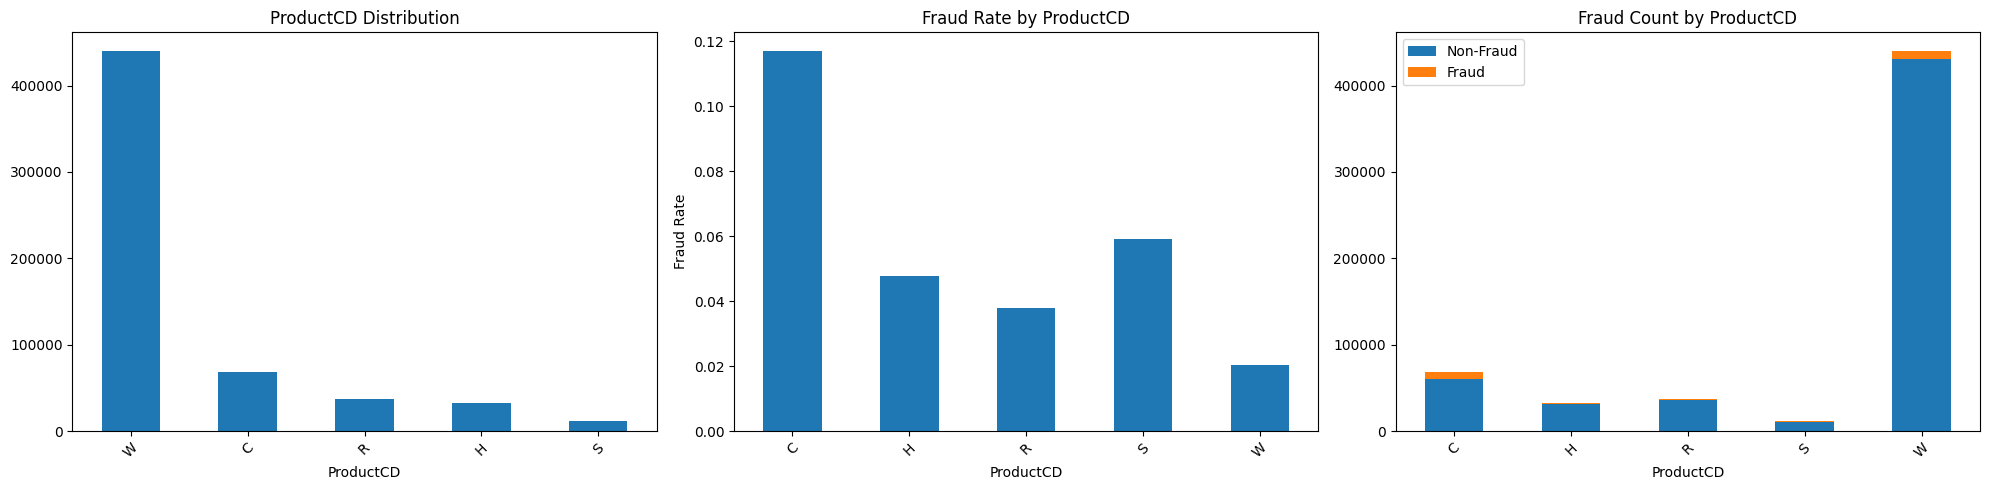


Fraud Rate by ProductCD:
ProductCD
C    0.116873
S    0.058996
H    0.047662
R    0.037826
W    0.020399
Name: isFraud, dtype: float64


In [38]:

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

df['ProductCD'].value_counts().plot(
    kind='bar', ax=axes[0], title='ProductCD Distribution'
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

fraud_by_product = df.groupby('ProductCD')['isFraud'].mean()
fraud_by_product.plot(
    kind='bar', ax=axes[1], title='Fraud Rate by ProductCD'
)
axes[1].set_ylabel('Fraud Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

product_fraud_counts = df.groupby(['ProductCD', 'isFraud']).size().unstack(fill_value=0)
product_fraud_counts.plot(
    kind='bar', stacked=True, ax=axes[2], title='Fraud Count by ProductCD'
)
axes[2].legend(['Non-Fraud', 'Fraud'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nFraud Rate by ProductCD:")
print(fraud_by_product.sort_values(ascending=False))


### Multi-analysis with all feature in gruop transaction feature

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20280\3935870366.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amount = product_data.groupby(amount_bins)['isFraud'].mean()


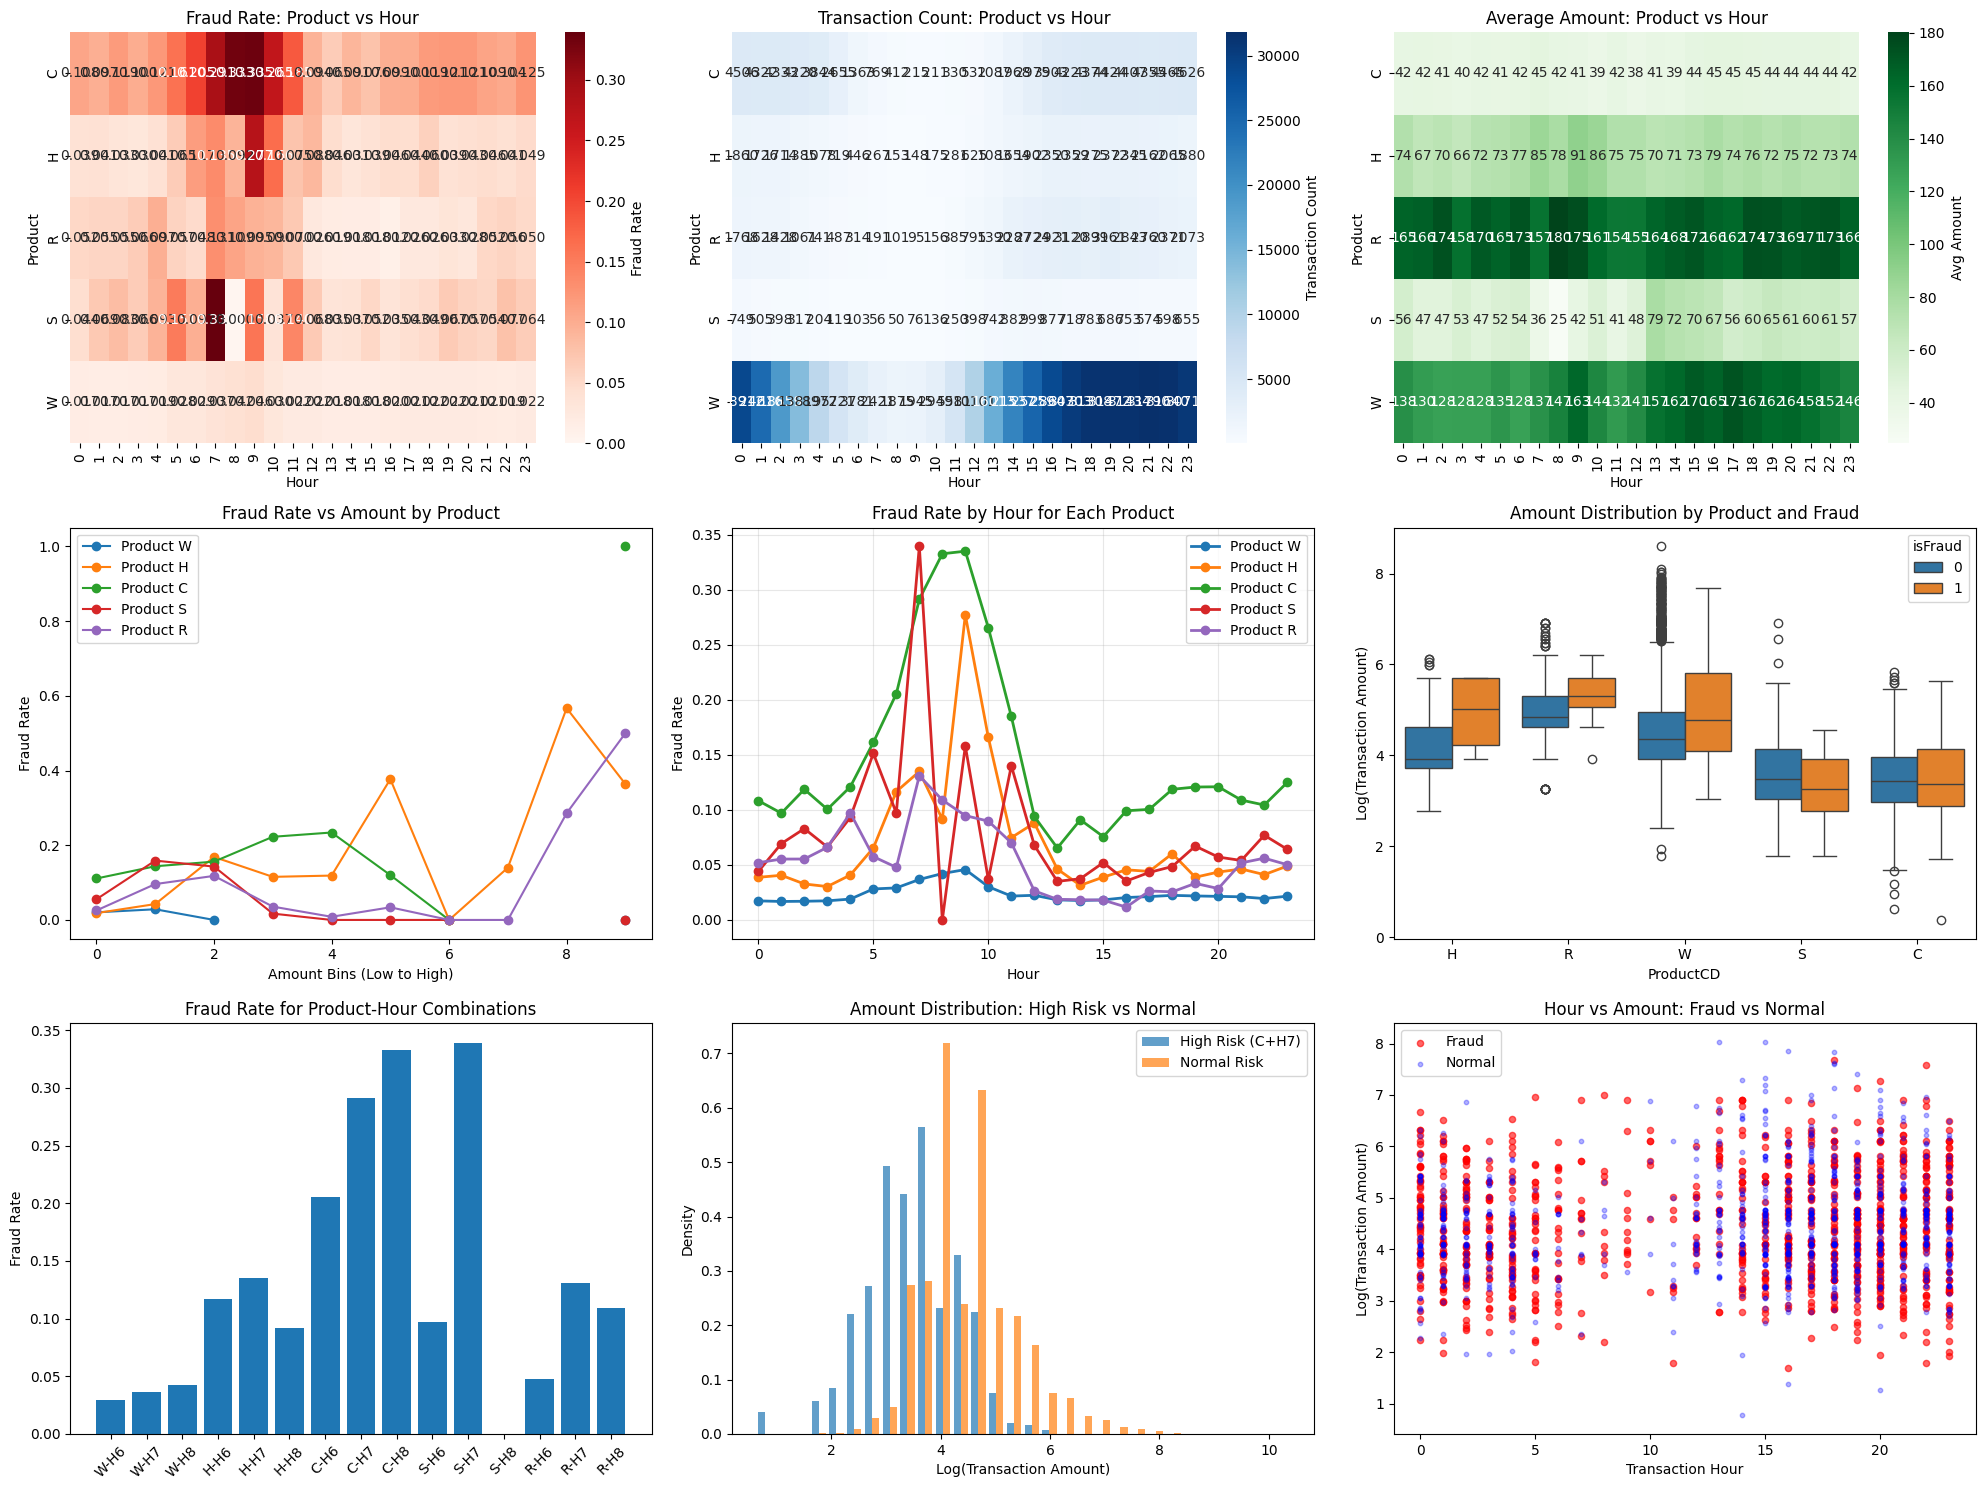

In [39]:
# Deep analysis of Product, Hours, Amount vs Fraud

plt.figure(figsize=(20, 15))

# 1. Fraud Rate by Product and Hour (Heatmap)
plt.subplot(3, 3, 1)
fraud_heatmap = df.groupby(['ProductCD', 'TransactionHour'])['isFraud'].mean().unstack(fill_value=0)
sns.heatmap(fraud_heatmap, annot=True, fmt='.3f', cmap='Reds', 
            cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate: Product vs Hour')
plt.ylabel('Product')
plt.xlabel('Hour')

# 2. Transaction Count by Product and Hour
plt.subplot(3, 3, 2)
count_heatmap = df.groupby(['ProductCD', 'TransactionHour']).size().unstack(fill_value=0)
sns.heatmap(count_heatmap, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Transaction Count'})
plt.title('Transaction Count: Product vs Hour')
plt.ylabel('Product')
plt.xlabel('Hour')

# 3. Average Amount by Product and Hour
plt.subplot(3, 3, 3)
amount_heatmap = df.groupby(['ProductCD', 'TransactionHour'])['TransactionAmt'].mean().unstack(fill_value=0)
sns.heatmap(amount_heatmap, annot=True, fmt='.0f', cmap='Greens',
            cbar_kws={'label': 'Avg Amount'})
plt.title('Average Amount: Product vs Hour')
plt.ylabel('Product')
plt.xlabel('Hour')

# 4. Fraud Rate vs Transaction Amount by Product
plt.subplot(3, 3, 4)
for product in df['ProductCD'].unique():
    if pd.notna(product):
        product_data = df[df['ProductCD'] == product]
        amount_bins = pd.cut(product_data['TransactionAmt'], bins=10)
        fraud_by_amount = product_data.groupby(amount_bins)['isFraud'].mean()
        plt.plot(range(len(fraud_by_amount)), fraud_by_amount.values, 
                marker='o', label=f'Product {product}')
plt.title('Fraud Rate vs Amount by Product')
plt.xlabel('Amount Bins (Low to High)')
plt.ylabel('Fraud Rate')
plt.legend()

# 5. Fraud Rate vs Hour by Product
plt.subplot(3, 3, 5)
for product in df['ProductCD'].unique():
    if pd.notna(product):
        product_data = df[df['ProductCD'] == product]
        hourly_fraud = product_data.groupby('TransactionHour')['isFraud'].mean()
        plt.plot(hourly_fraud.index, hourly_fraud.values, 
                marker='o', label=f'Product {product}', linewidth=2)
plt.title('Fraud Rate by Hour for Each Product')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Box plot: Amount distribution by Product and Fraud
plt.subplot(3, 3, 6)
df_sample = df.sample(10000)  # Sample for better visualization
sns.boxplot(data=df_sample, x='ProductCD', y='TransactionAmt_log', hue='isFraud')
plt.title('Amount Distribution by Product and Fraud')
plt.ylabel('Log(Transaction Amount)')
plt.yscale('linear')

# 7. High-risk combinations (Product C + Hour 7)
plt.subplot(3, 3, 7)
risk_combinations = []
fraud_rates = []
labels = []

for product in df['ProductCD'].unique():
    if pd.notna(product):
        for hour in [6, 7, 8]:  # Focus on high-risk hours
            subset = df[(df['ProductCD'] == product) & (df['TransactionHour'] == hour)]
            if len(subset) > 10:  # Only if enough samples
                fraud_rate = subset['isFraud'].mean()
                risk_combinations.append(f'{product}-H{hour}')
                fraud_rates.append(fraud_rate)
                labels.append(f'Product {product}, Hour {hour}')

plt.bar(range(len(fraud_rates)), fraud_rates)
plt.xticks(range(len(fraud_rates)), risk_combinations, rotation=45)
plt.title('Fraud Rate for Product-Hour Combinations')
plt.ylabel('Fraud Rate')

# 8. Amount patterns for high-risk scenarios
plt.subplot(3, 3, 8)
high_risk = df[(df['ProductCD'] == 'C') & (df['TransactionHour'] == 7)]
normal_risk = df[(df['ProductCD'] != 'C') & (df['TransactionHour'] != 7)]

plt.hist([high_risk['TransactionAmt_log'], normal_risk['TransactionAmt_log']], 
         bins=30, alpha=0.7, density=True,
         label=['High Risk (C+H7)', 'Normal Risk'])
plt.title('Amount Distribution: High Risk vs Normal')
plt.xlabel('Log(Transaction Amount)')
plt.ylabel('Density')
plt.legend()

# 9. 3D visualization concept (simplified as scatter)
plt.subplot(3, 3, 9)
fraud_data = df[df['isFraud'] == 1].sample(min(1000, len(df[df['isFraud'] == 1])))
normal_data = df[df['isFraud'] == 0].sample(min(1000, len(df[df['isFraud'] == 0])))

plt.scatter(fraud_data['TransactionHour'], fraud_data['TransactionAmt_log'], 
           c='red', alpha=0.6, s=20, label='Fraud')
plt.scatter(normal_data['TransactionHour'], normal_data['TransactionAmt_log'], 
           c='blue', alpha=0.3, s=10, label='Normal')
plt.title('Hour vs Amount: Fraud vs Normal')
plt.xlabel('Transaction Hour')
plt.ylabel('Log(Transaction Amount)')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='ProductCD', ylabel='TransactionAmt_log'>

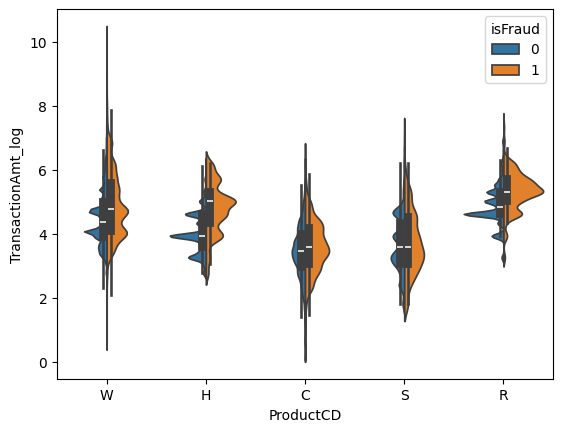

In [41]:
sns.violinplot(data=df, x="ProductCD", y="TransactionAmt_log", hue="isFraud", split=True)


### Pre-processing direction for this group 

- All features are not null 

- Log transform the trans amt feature to avoid skew and sensitive with out liers.   

## Email Feature 

### P_emaildomain 

In [48]:
# missing value of p_emaildomain
cnt_missing = df['P_emaildomain'].isnull().sum()
# percentage of missing value
pct_missing = df['P_emaildomain'].isnull().mean()

print(f"Missing values in P_emaildomain: {cnt_missing} ({pct_missing:.2%})")



Missing values in P_emaildomain: 94456 (15.99%)


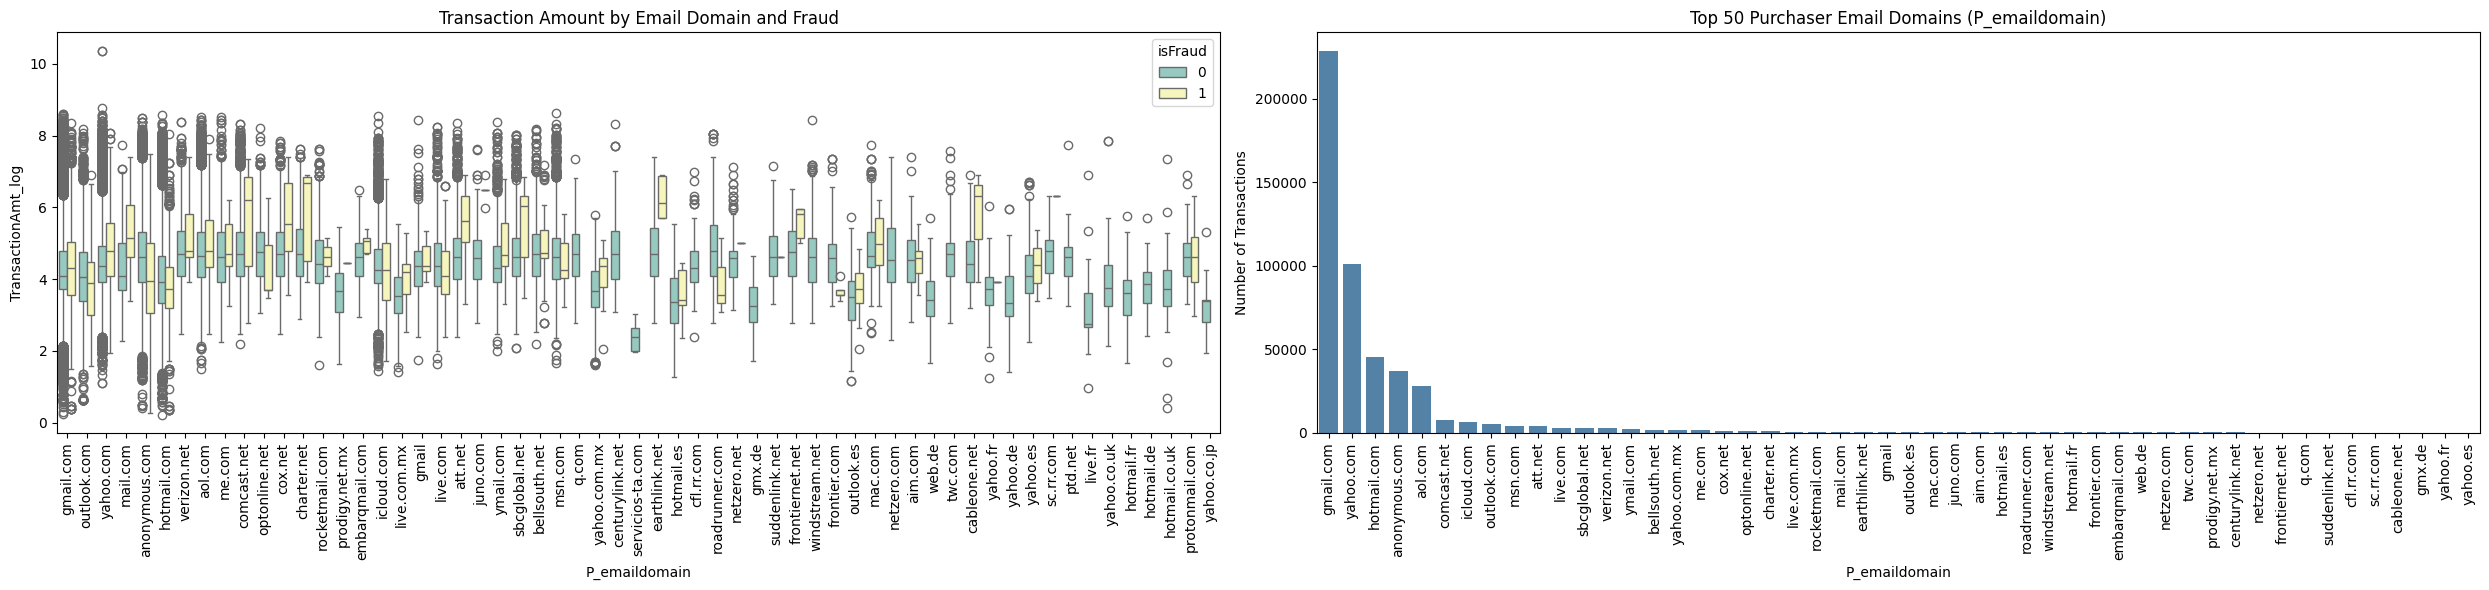

In [60]:

fig, axes = plt.subplots(1, 2, figsize=(25, 6))


sns.boxplot(data=df, x='P_emaildomain', y='TransactionAmt_log', hue='isFraud',
            palette="Set3", ax=axes[0])
axes[0].set_title("Transaction Amount by Email Domain and Fraud")
axes[0].tick_params(axis='x', rotation=90)

p_email_counts = df['P_emaildomain'].value_counts().head(50)
sns.barplot(x=p_email_counts.index, y=p_email_counts.values, color='steelblue', ax=axes[1])
axes[1].set_title("Top 50 Purchaser Email Domains (P_emaildomain)")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()


In [49]:
p_email_stats = df.groupby('P_emaildomain')['isFraud'].agg(total='count', fraud='sum')
p_email_stats['fraud_rate'] = p_email_stats['fraud'] / p_email_stats['total']
p_email_stats.sort_values('fraud_rate', ascending=False).head(10)

,total,fraud,fraud_rate
P_emaildomain,,,
protonmail.com,76,31,0.407895
mail.com,559,106,0.189624
outlook.es,438,57,0.130137
aim.com,315,40,0.126984
outlook.com,5096,482,0.094584
hotmail.es,305,20,0.065574
live.com.mx,749,41,0.054740
hotmail.com,45250,2396,0.052950
gmail.com,228355,9943,0.043542


C:\Users\LEGION\AppData\Local\Temp\ipykernel_20280\271132515.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(p_email_stats.index, rotation=45, ha='right')


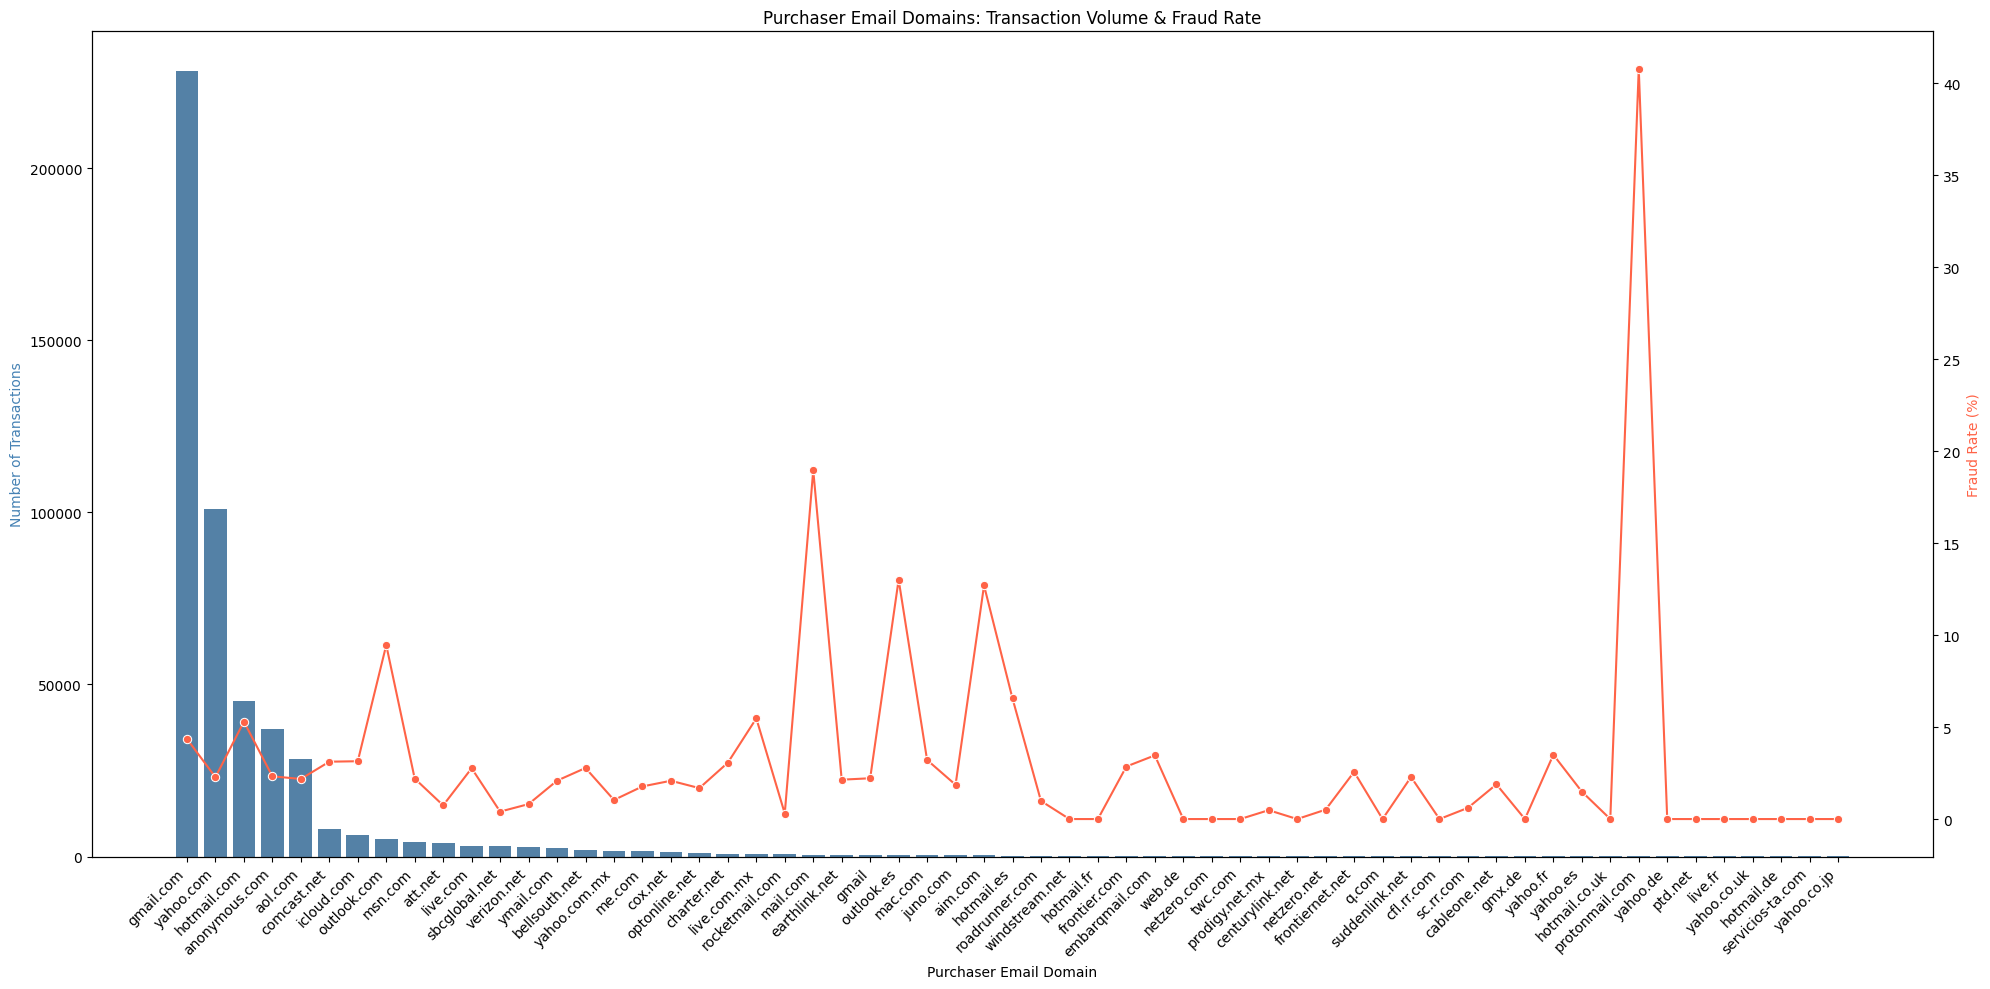

In [50]:


p_email_stats = df.groupby('P_emaildomain')['isFraud'].agg(total='count', fraud='sum')
p_email_stats['fraud_rate'] = p_email_stats['fraud'] / p_email_stats['total']
p_email_stats = p_email_stats.sort_values('total', ascending=False).head(200)  

fig, ax1 = plt.subplots(figsize=(20,10))

sns.barplot(x=p_email_stats.index, y=p_email_stats['total'], color='steelblue', ax=ax1)
ax1.set_ylabel("Number of Transactions", color="steelblue")
ax1.set_xlabel("Purchaser Email Domain")
ax1.set_xticklabels(p_email_stats.index, rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(x=p_email_stats.index, y=p_email_stats['fraud_rate']*100, 
             marker='o', sort=False, color='tomato', ax=ax2)
ax2.set_ylabel("Fraud Rate (%)", color="tomato")

plt.title("Purchaser Email Domains: Transaction Volume & Fraud Rate")
plt.tight_layout()
plt.show()

The figure shows that protonmail.com has the highest observed fraud rate (around 40%), but this is based on a very small number of transactions, which may introduce bias. Similarly, domains such as mail.com, outlook.es, and aim.com record fraud rates above 15%, yet their sample sizes are also limited, so these results should be interpreted with caution.

In contrast, major “big tech” domains like gmail.com, yahoo.com, and hotmail.com account for the majority of transactions and exhibit fraud rates below 10%. This suggests that while fraud does occur across all email providers, rare or niche domains tend to show disproportionately higher fraud risk, although their impact on the overall dataset is smaller due to low transaction volume.

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20280\2232610326.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=email_stats2.index, y=email_stats2['fraud_rate']*100, palette="Set2", ax=axes[0])


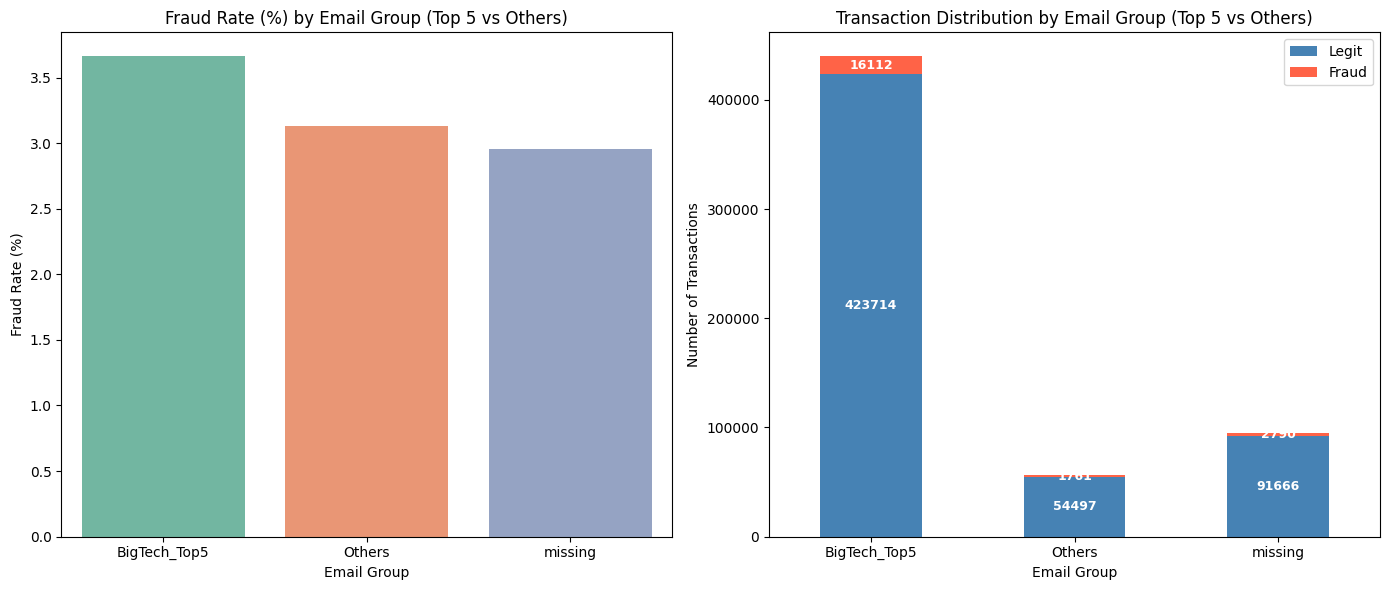

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính toán lại cho chắc
top5_domains = df['P_emaildomain'].value_counts().head(5).index.tolist()

def categorize_email(domain):
    if pd.isnull(domain):
        return "missing"
    domain = domain.lower()
    if domain in top5_domains:
        return "BigTech_Top5"
    else:
        return "Others"

df['email_group2'] = df['P_emaildomain'].apply(categorize_email)

# Fraud rate
email_stats2 = df.groupby('email_group2')['isFraud'].agg(total='count', fraud='sum')
email_stats2['fraud_rate'] = email_stats2['fraud'] / email_stats2['total']

# Transaction distribution
email_group_stats2 = df.groupby(['email_group2','isFraud']).size().unstack(fill_value=0)
email_group_stats2.columns = ['Legit','Fraud']

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# 1. Fraud Rate barplot
sns.barplot(x=email_stats2.index, y=email_stats2['fraud_rate']*100, palette="Set2", ax=axes[0])
axes[0].set_title("Fraud Rate (%) by Email Group (Top 5 vs Others)")
axes[0].set_xlabel("Email Group")
axes[0].set_ylabel("Fraud Rate (%)")

# 2. Transaction Distribution stacked bar
email_group_stats2.plot(kind='bar', stacked=True, ax=axes[1],
                        color=['steelblue','tomato'], legend=False)

for container in axes[1].containers:
    axes[1].bar_label(container, label_type='center', color='white',
                      fontsize=9, fontweight='bold')

axes[1].set_title("Transaction Distribution by Email Group (Top 5 vs Others)")
axes[1].set_xlabel("Email Group")
axes[1].set_ylabel("Number of Transactions")
axes[1].legend(["Legit","Fraud"])
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


- When using raw columns to train model which can be overfit because of small number of email (like protonemail.com) with very high fraud rate 

*Pre-processing strategy:* `Fill missing value with 'unkown' , bining to three type of email like above (The fraud rate is more balance between type of email)`

### R_emaildomain 

In [55]:
# missing value of R_emaildomain
cnt_missing = df['R_emaildomain'].isnull().sum()
# percentage of missing value
pct_missing = df['R_emaildomain'].isnull().mean()

print(f"Missing values in R_emaildomain: {cnt_missing} ({pct_missing:.2%})")



Missing values in R_emaildomain: 453249 (76.75%)


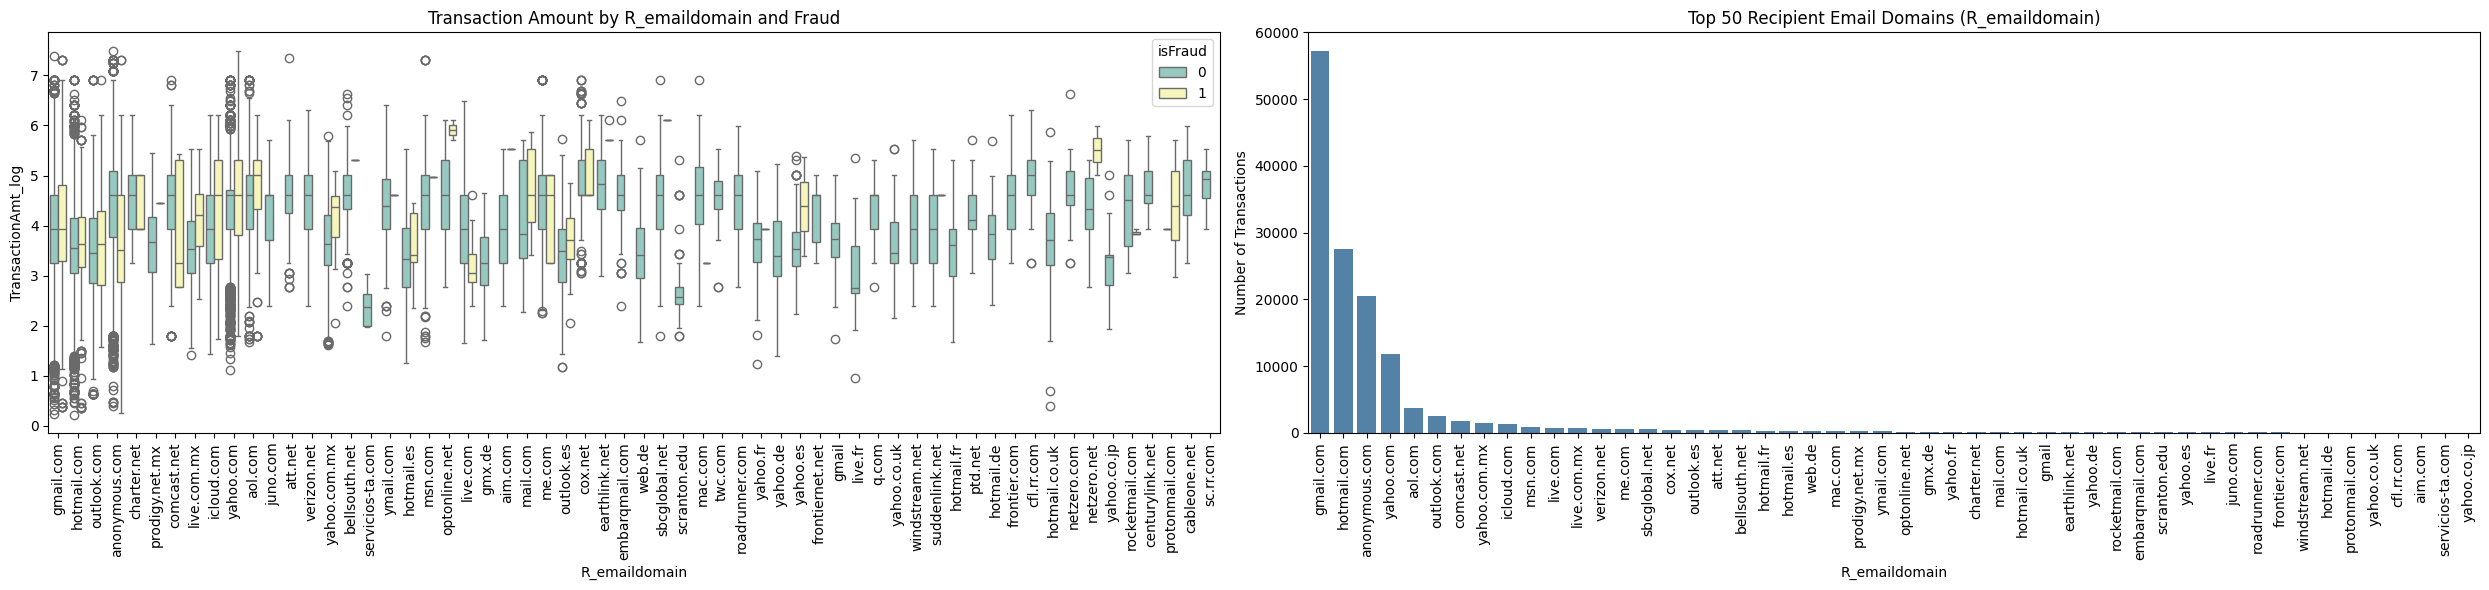

In [57]:

fig, axes = plt.subplots(1, 2, figsize=(25, 6))


sns.boxplot(data=df, x='R_emaildomain', y='TransactionAmt_log', hue='isFraud',
            palette="Set3", ax=axes[0])
axes[0].set_title("Transaction Amount by R_emaildomain and Fraud")
axes[0].tick_params(axis='x', rotation=90)

r_email_counts = df['R_emaildomain'].value_counts().head(50)
sns.barplot(x=r_email_counts.index, y=r_email_counts.values, color='steelblue', ax=axes[1])
axes[1].set_title("Top 50 Recipient Email Domains (R_emaildomain)")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()


C:\Users\LEGION\AppData\Local\Temp\ipykernel_20280\3041982393.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(r_email_stats.index, rotation=45, ha='right')


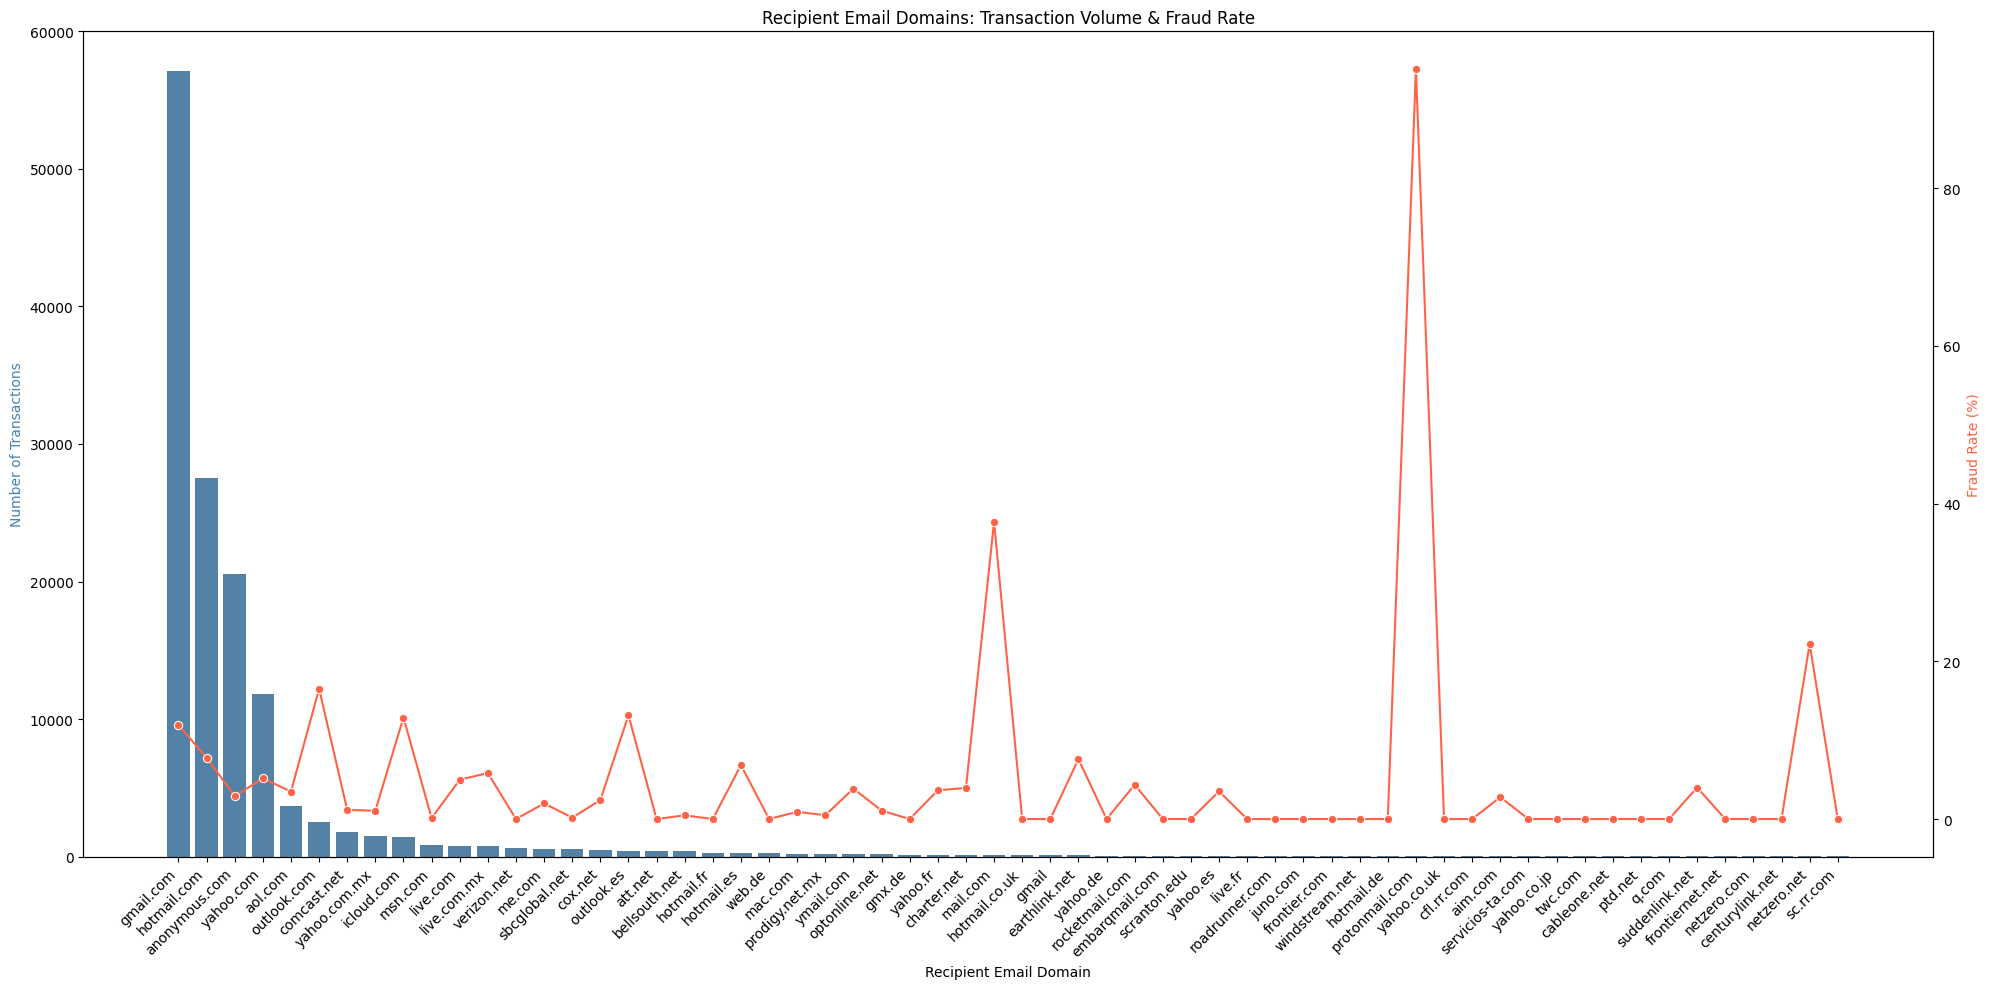

In [61]:


r_email_stats = df.groupby('R_emaildomain')['isFraud'].agg(total='count', fraud='sum')
r_email_stats['fraud_rate'] = r_email_stats['fraud'] / r_email_stats['total']
r_email_stats = r_email_stats.sort_values('total', ascending=False).head(200)

fig, ax1 = plt.subplots(figsize=(20,10))

sns.barplot(x=r_email_stats.index, y=r_email_stats['total'], color='steelblue', ax=ax1)
ax1.set_ylabel("Number of Transactions", color="steelblue")
ax1.set_xlabel("Recipient Email Domain")
ax1.set_xticklabels(r_email_stats.index, rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(x=r_email_stats.index, y=r_email_stats['fraud_rate']*100, 
             marker='o', sort=False, color='tomato', ax=ax2)
ax2.set_ylabel("Fraud Rate (%)", color="tomato")

plt.title("Recipient Email Domains: Transaction Volume & Fraud Rate")
plt.tight_layout()
plt.show()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20280\2341319372.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=email_stats2.index, y=email_stats2['fraud_rate']*100, palette="Set2", ax=axes[0])


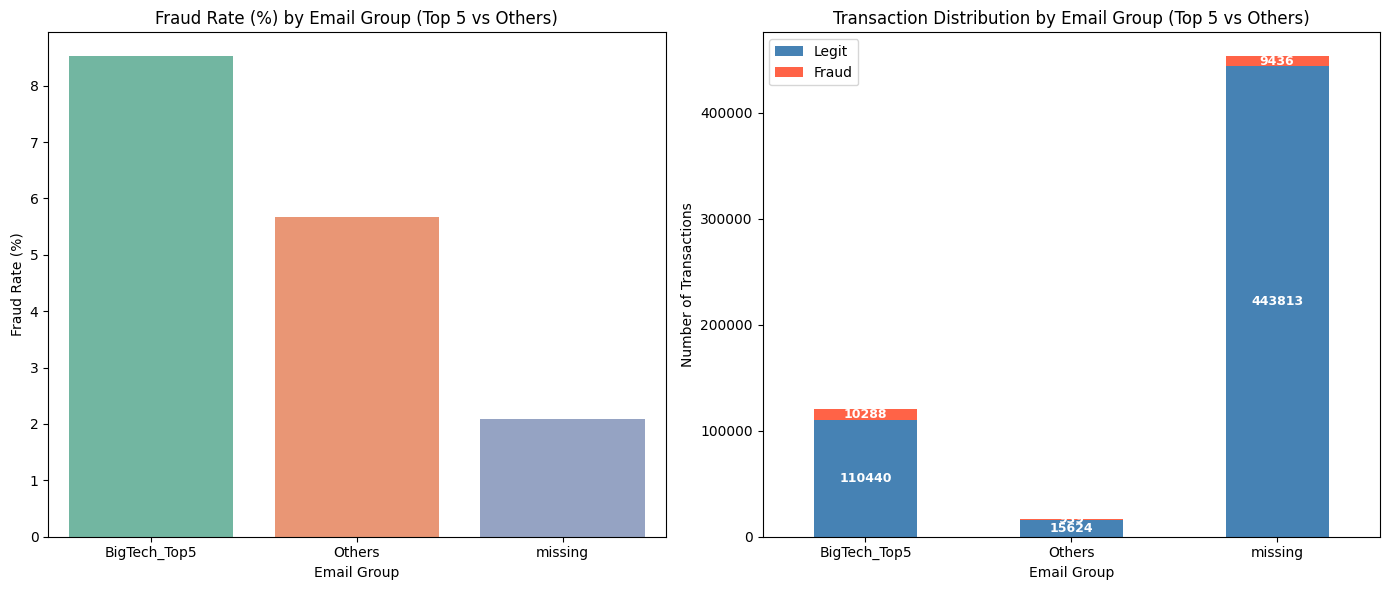

In [62]:

top5_domains = df['R_emaildomain'].value_counts().head(5).index.tolist()

def categorize_email(domain):
    if pd.isnull(domain):
        return "missing"
    domain = domain.lower()
    if domain in top5_domains:
        return "BigTech_Top5"
    else:
        return "Others"

df['email_group2'] = df['R_emaildomain'].apply(categorize_email)

# Fraud rate
email_stats2 = df.groupby('email_group2')['isFraud'].agg(total='count', fraud='sum')
email_stats2['fraud_rate'] = email_stats2['fraud'] / email_stats2['total']

# Transaction distribution
email_group_stats2 = df.groupby(['email_group2','isFraud']).size().unstack(fill_value=0)
email_group_stats2.columns = ['Legit','Fraud']

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# 1. Fraud Rate barplot
sns.barplot(x=email_stats2.index, y=email_stats2['fraud_rate']*100, palette="Set2", ax=axes[0])
axes[0].set_title("Fraud Rate (%) by Email Group (Top 5 vs Others)")
axes[0].set_xlabel("Email Group")
axes[0].set_ylabel("Fraud Rate (%)")

# 2. Transaction Distribution stacked bar
email_group_stats2.plot(kind='bar', stacked=True, ax=axes[1],
                        color=['steelblue','tomato'], legend=False)

for container in axes[1].containers:
    axes[1].bar_label(container, label_type='center', color='white',
                      fontsize=9, fontweight='bold')

axes[1].set_title("Transaction Distribution by Email Group (Top 5 vs Others)")
axes[1].set_xlabel("Email Group")
axes[1].set_ylabel("Number of Transactions")
axes[1].legend(["Legit","Fraud"])
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


### Pre-processing Strategy 

- Fill na with Unkown email and bining to avoid overfit 

## Address feature
- **addr1**: Billing region.  
- **addr2**: Billing country.  

### Addr1 : billing region 

In [6]:
# missing value of addr1
cnt_missing = df['addr1'].isnull().sum()
# percentage of missing value
pct_missing = df['addr1'].isnull().mean()
print(f"Missing values in addr1: {cnt_missing} ({pct_missing:.2%})")


Missing values in addr1: 65706 (11.13%)


In [24]:
df['addr1'].unique()

array([315., 325., 330., 476., 420., 272., 126., 337., 204.,  -1., 226.,
       170., 184., 264., 299., 441., 472., 251., 469., 191., 485., 122.,
       220., 205., 387., 181., 231., 436., 327., 343., 123., 502., 269.,
       158., 433., 143., 225., 492., 177., 512., 310., 308., 418., 494.,
       253., 428., 203., 110., 444., 498., 194., 536., 384., 324., 295.,
       448., 157., 171., 224., 491., 274., 432., 459., 106., 296., 254.,
       452., 347., 335., 305., 161., 221., 154., 130., 465., 451., 331.,
       511., 486., 312., 242., 131., 508., 332., 283., 216., 431., 391.,
       333., 496., 304., 167., 261., 399., 164., 142., 393., 258., 375.,
       483., 404., 482., 148., 218., 127., 403., 374., 477., 478., 241.,
       504., 453., 535., 100., 239., 152., 500., 356., 198., 162., 244.,
       520., 531., 401., 427., 352., 540., 456., 371., 409., 529., 505.,
       503., 346., 359., 499., 298., 190., 454., 172., 145., 493., 119.,
       521., 270., 395., 366., 348., 313., 338., 13

In [7]:
df['addr1'].head(10)

0    315.0
1    325.0
2    330.0
3    476.0
4    420.0
5    272.0
6    126.0
7    325.0
8    337.0
9    204.0
Name: addr1, dtype: float64

- Although this feature have value like a numerical but this is a postcode of a region -> We need to treat it like a category feature 

In [8]:
df['addr1'].unique().size

333

In [17]:
# fill missing with -1 stand for unknown 
df['addr1'].fillna(-1, inplace=True)

C:\Users\LEGION\AppData\Local\Temp\ipykernel_15320\2599843821.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['addr1'].fillna(-1, inplace=True)


- 333 region 

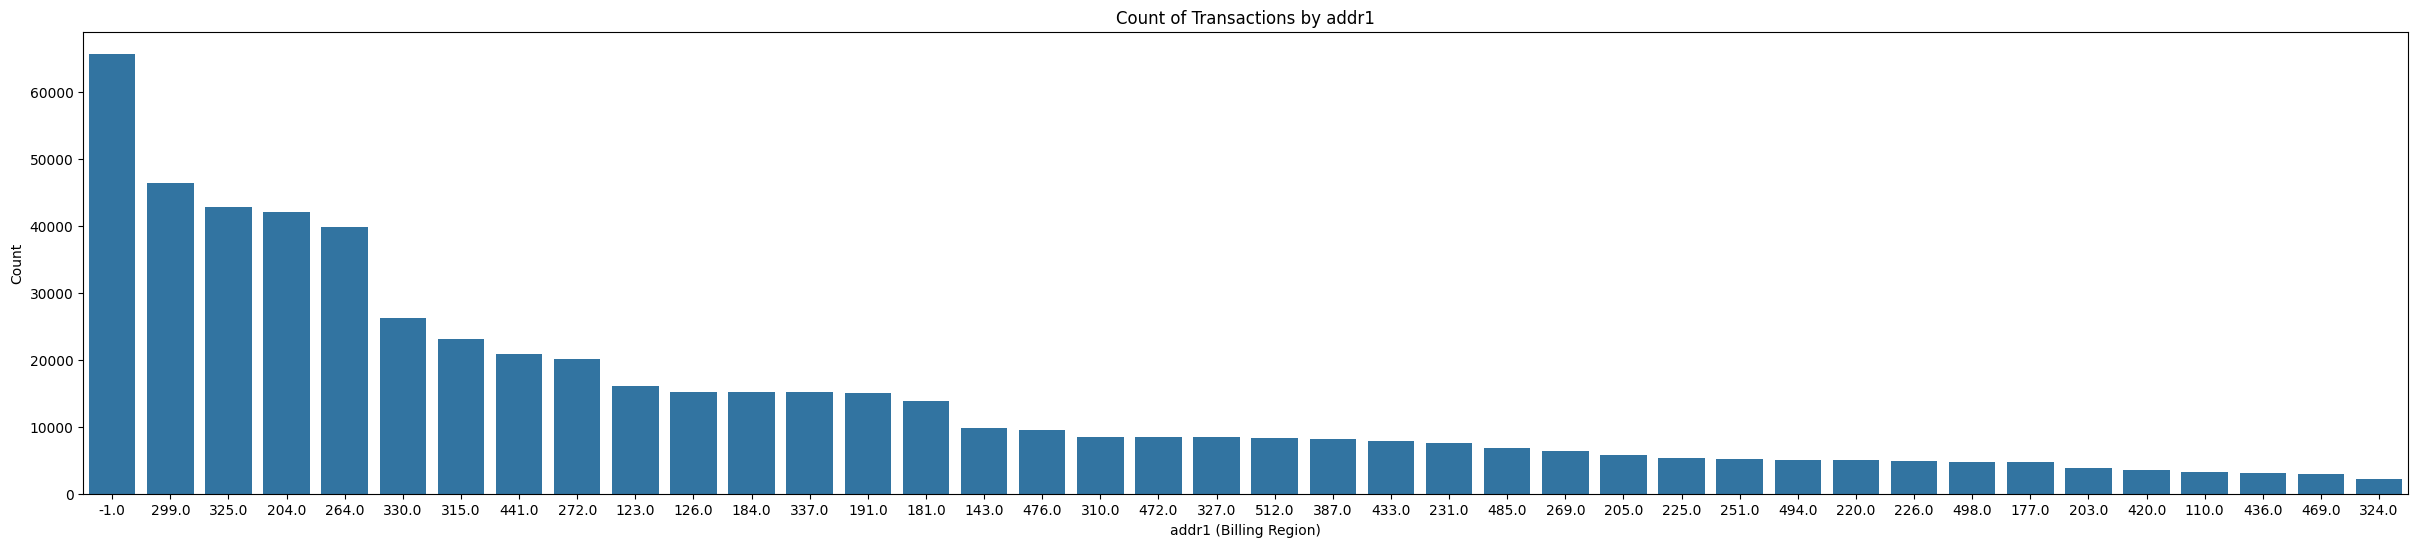

C:\Users\LEGION\AppData\Local\Temp\ipykernel_15320\756640223.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=addr1_fraud_rate.index, y=addr1_fraud_rate.values, palette='viridis')


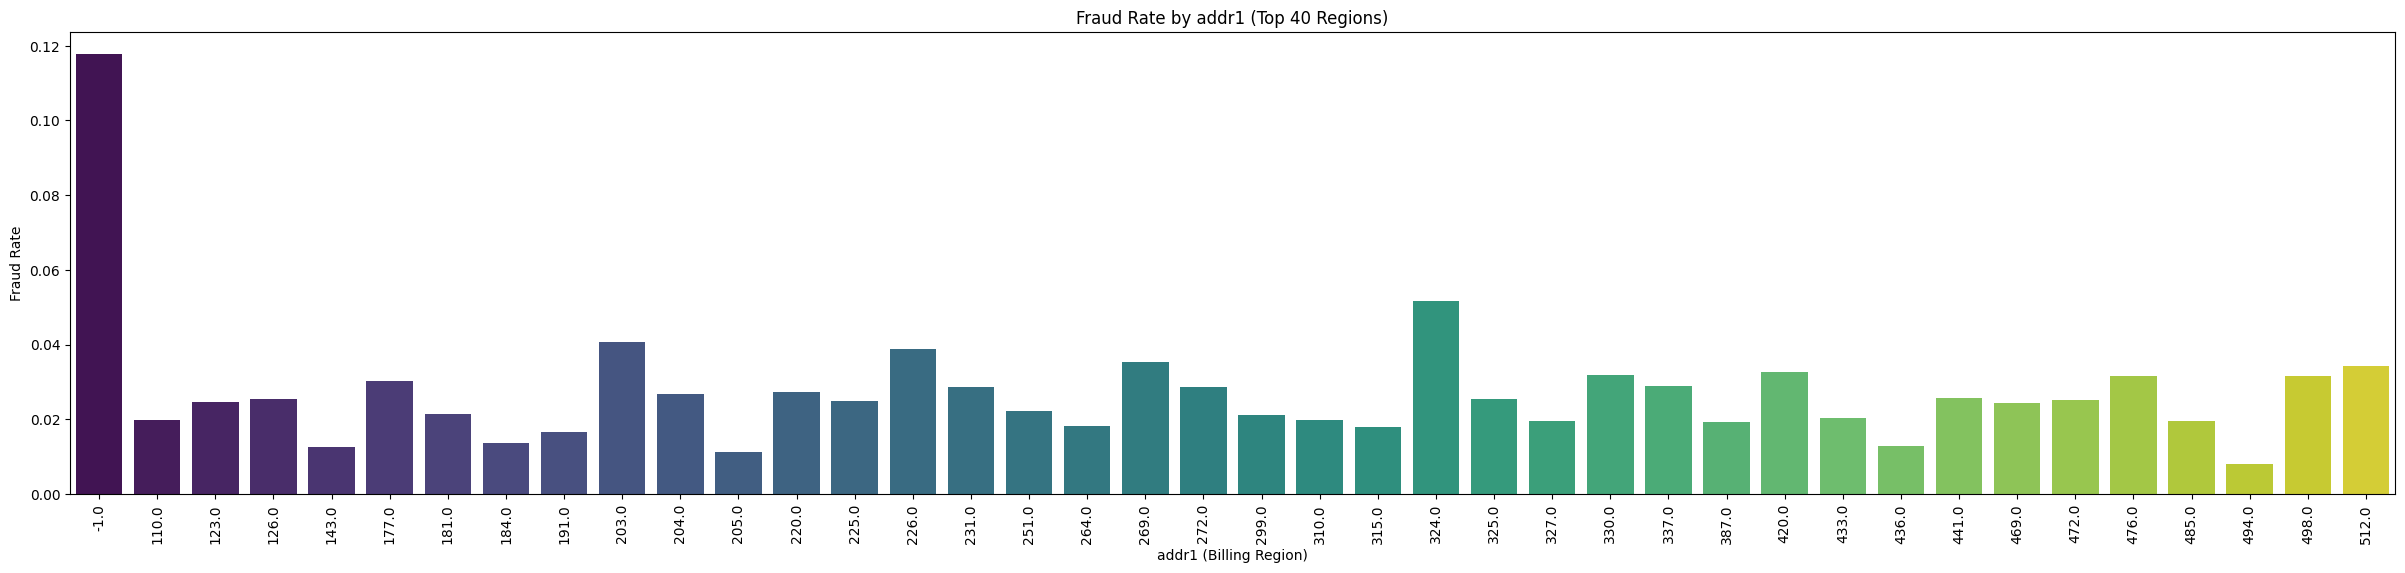

In [18]:
top_addr1 = df['addr1'].value_counts().sort_values(ascending=False).head(40)

# bar plot of addr1
plt.figure(figsize=(30,6))
sns.countplot(x='addr1', data=df, order=top_addr1.index)
plt.title('Count of Transactions by addr1')
plt.xlabel('addr1 (Billing Region)')
plt.ylabel('Count')
plt.show()

# bar plot of addr1 vs fraud rate 
addr1_fraud_rate = df.groupby('addr1')['isFraud'].mean().loc[top_addr1.index]
plt.figure(figsize=(30,6))
sns.barplot(x=addr1_fraud_rate.index, y=addr1_fraud_rate.values, palette='viridis')
plt.title('Fraud Rate by addr1 (Top 40 Regions)')
plt.xlabel('addr1 (Billing Region)')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=90)
plt.show()




In [19]:
# binning addr1 into 5 bins
df['addr1_binned'] = pd.qcut(df['addr1'].rank(method='first'), q=5, labels=False)
# Although this feature have value like a numerical but this is a postcode of a region -> We need to treat it like a category feature
df['addr1_binned'].value_counts().sort_index()


addr1_binned
0    118108
1    118108
2    118108
3    118108
4    118108
Name: count, dtype: int64

C:\Users\LEGION\AppData\Local\Temp\ipykernel_15320\2701332749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='addr1_binned', y='isFraud', data=df, palette='magma')


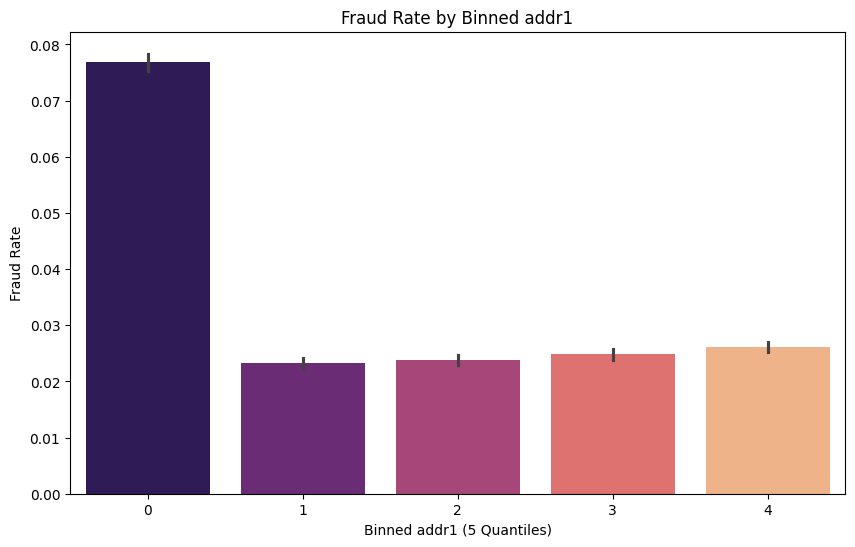

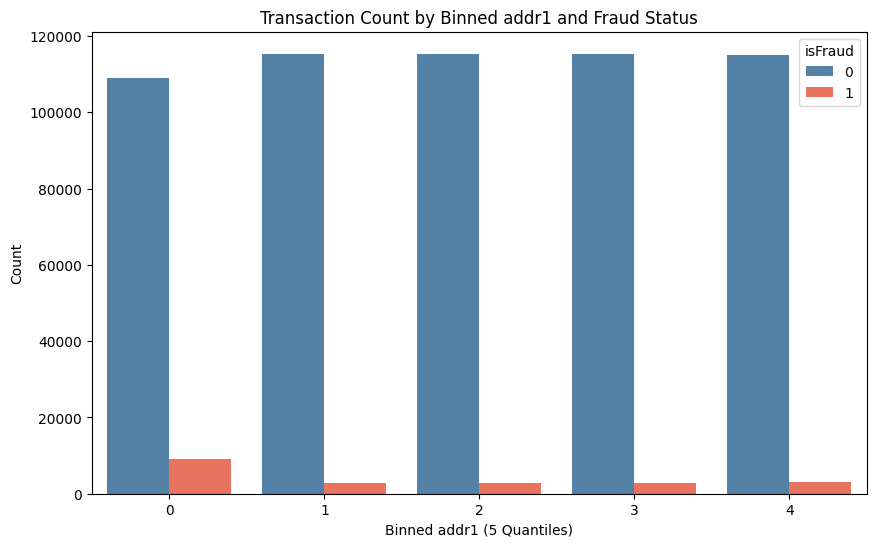

In [20]:
# bar plot of addr1_binned vs fraud rate
plt.figure(figsize=(10,6))
sns.barplot(x='addr1_binned', y='isFraud', data=df, palette='magma')
plt.title('Fraud Rate by Binned addr1')
plt.xlabel('Binned addr1 (5 Quantiles)')
plt.ylabel('Fraud Rate')
plt.show()

# barplot of addr1_binned vs isFraud
plt.figure(figsize=(10,6))
sns.countplot(x='addr1_binned', hue='isFraud', data=df,
                palette=['steelblue', 'tomato'])
plt.title('Transaction Count by Binned addr1 and Fraud Status')
plt.xlabel('Binned addr1 (5 Quantiles)')
plt.ylabel('Count')
plt.show()




### Addr2: Billing county 

In [22]:
df['addr2'].isnull().sum()

np.int64(65706)

In [23]:
# unique value of addr2
df['addr2'].unique()


array([ 87.,  nan,  96.,  35.,  60.,  98.,  43.,  65.,  32.,  13.,  31.,
       101.,  24.,  16.,  15.,  19.,  71.,  59., 102.,  44.,  26.,  69.,
        47.,  78.,  88.,  66.,  72.,  22.,  57.,  25.,  17.,  30.,  29.,
        21.,  14.,  49.,  83.,  75.,  34.,  86.,  48.,  68.,  23.,  70.,
        62.,  54.,  50.,  52.,  39.,  76.,  10.,  73.,  97.,  63.,  27.,
        28.,  38.,  74.,  77.,  92.,  79.,  84.,  82.,  40.,  36.,  46.,
        18.,  20.,  89.,  61.,  94., 100.,  55.,  51.,  93.])

In [26]:
# fill missing with -1 stand for unknown
df['addr2'].fillna(-1, inplace=True)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_15320\3934056580.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['addr2'].fillna(-1, inplace=True)


In [27]:
df['addr2'].unique()


array([ 87.,  -1.,  96.,  35.,  60.,  98.,  43.,  65.,  32.,  13.,  31.,
       101.,  24.,  16.,  15.,  19.,  71.,  59., 102.,  44.,  26.,  69.,
        47.,  78.,  88.,  66.,  72.,  22.,  57.,  25.,  17.,  30.,  29.,
        21.,  14.,  49.,  83.,  75.,  34.,  86.,  48.,  68.,  23.,  70.,
        62.,  54.,  50.,  52.,  39.,  76.,  10.,  73.,  97.,  63.,  27.,
        28.,  38.,  74.,  77.,  92.,  79.,  84.,  82.,  40.,  36.,  46.,
        18.,  20.,  89.,  61.,  94., 100.,  55.,  51.,  93.])

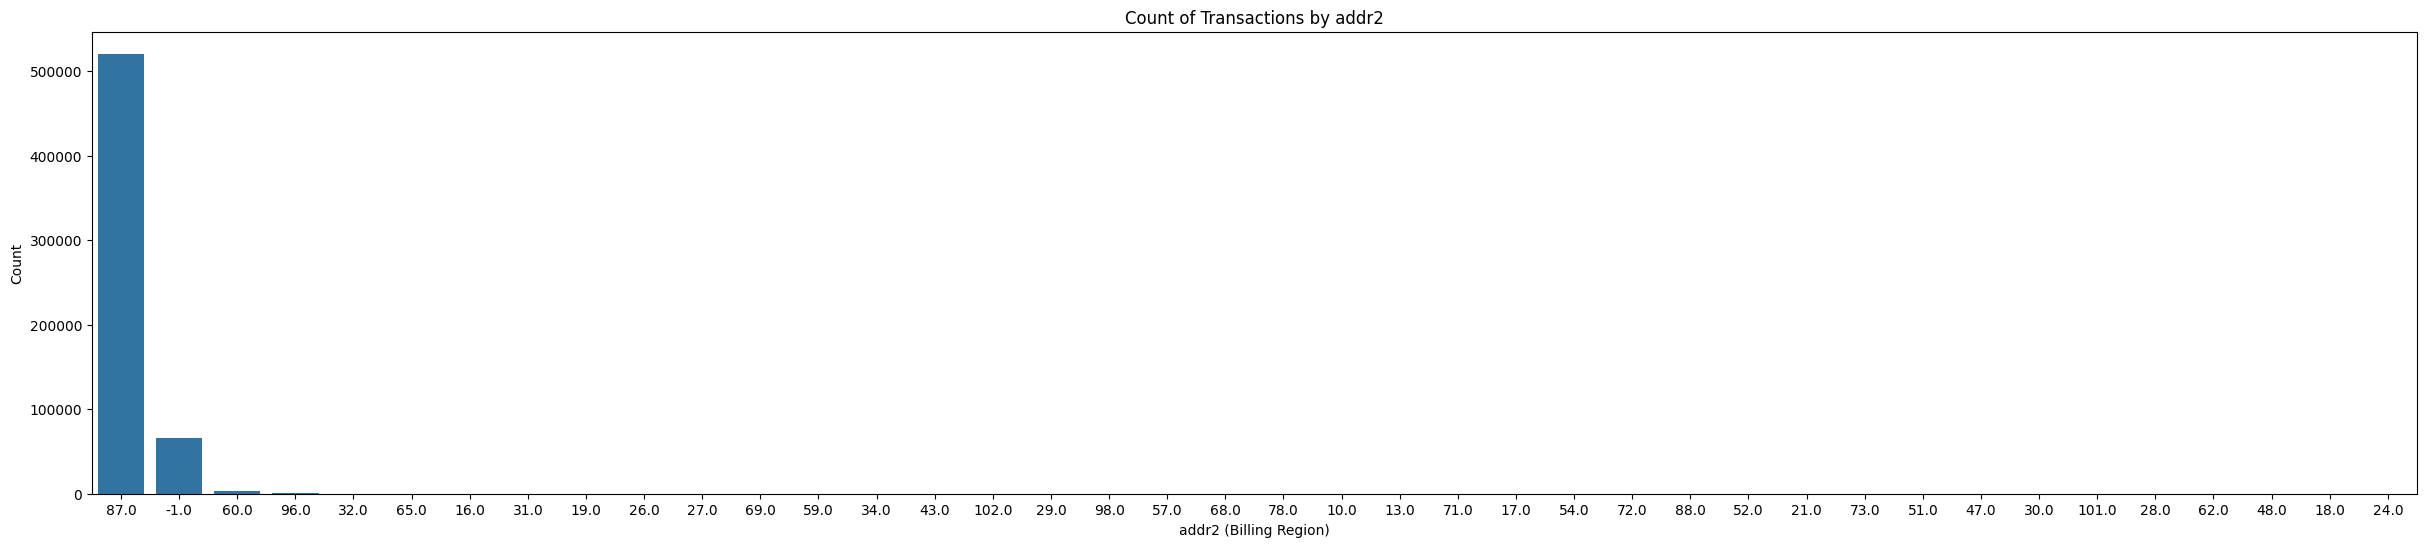

C:\Users\LEGION\AppData\Local\Temp\ipykernel_15320\1666332105.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=addr2_fraud_rate.index, y=addr2_fraud_rate.values, palette='viridis')


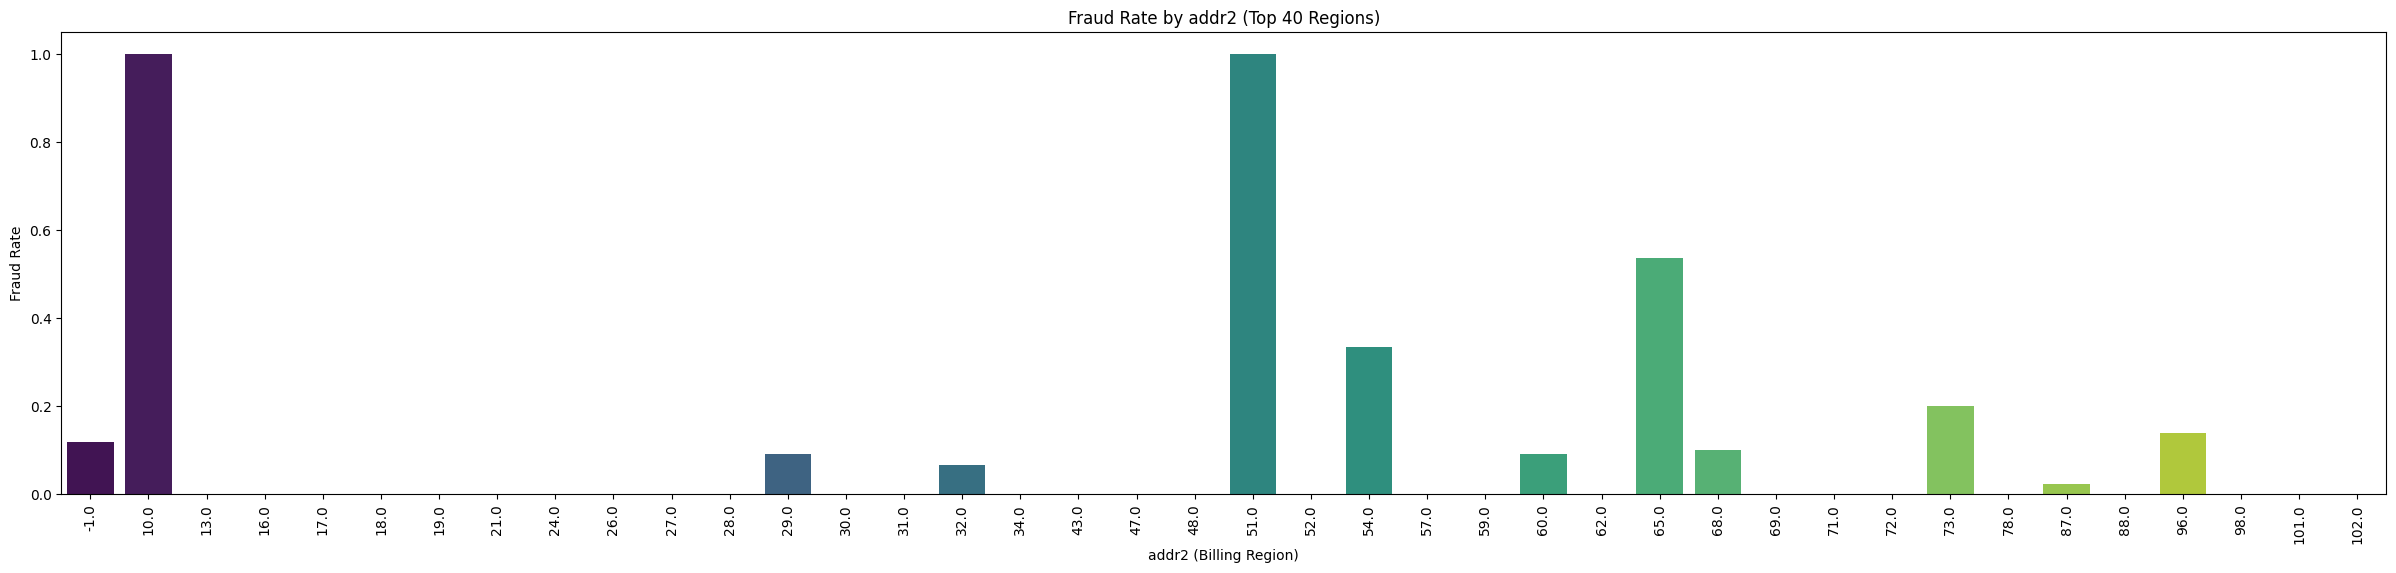

In [28]:
top_addr1 = df['addr2'].value_counts().sort_values(ascending=False).head(40)

# bar plot of addr1
plt.figure(figsize=(30,6))
sns.countplot(x='addr2', data=df, order=top_addr1.index)
plt.title('Count of Transactions by addr2')
plt.xlabel('addr2 (Billing Region)')
plt.ylabel('Count')
plt.show()

# bar plot of addr2 vs fraud rate
addr2_fraud_rate = df.groupby('addr2')['isFraud'].mean().loc[top_addr1.index]
plt.figure(figsize=(30,6))
sns.barplot(x=addr2_fraud_rate.index, y=addr2_fraud_rate.values, palette='viridis')
plt.title('Fraud Rate by addr2 (Top 40 Regions)')
plt.xlabel('addr2 (Billing Region)')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=90)
plt.show()



In [3]:
# binning addr1 into 5 bins
df['addr2_binned'] = pd.qcut(df['addr2'].rank(method='first'), q=5, labels=False)
# Although this feature have value like a numerical but this is a postcode of a region -> We need to treat it like a category feature
df['addr2_binned'].value_counts().sort_index()

addr2_binned
0.0    104967
1.0    104967
2.0    104966
3.0    104967
4.0    104967
Name: count, dtype: int64

C:\Users\LEGION\AppData\Local\Temp\ipykernel_18564\109348009.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='addr2_binned', y='isFraud', data=df, palette='magma')


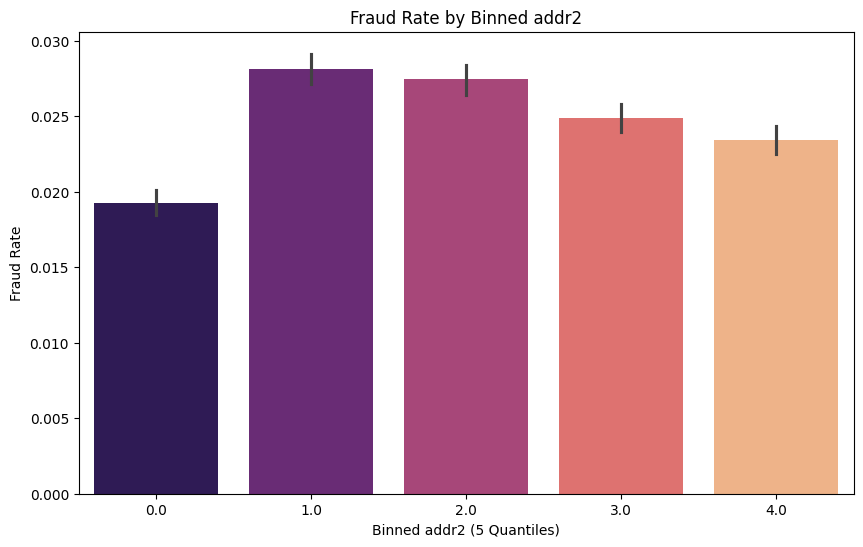

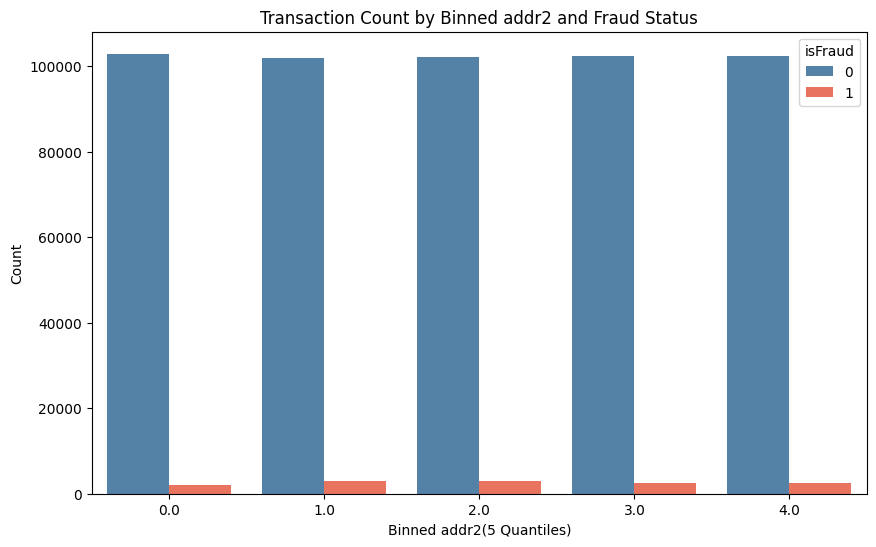

In [4]:
# bar plot of addr2_binned vs fraud rate
plt.figure(figsize=(10,6))
sns.barplot(x='addr2_binned', y='isFraud', data=df, palette='magma')
plt.title('Fraud Rate by Binned addr2')
plt.xlabel('Binned addr2 (5 Quantiles)')
plt.ylabel('Fraud Rate')
plt.show()

# barplot of addr2_binned vs isFraud
plt.figure(figsize=(10,6))
sns.countplot(x='addr2_binned', hue='isFraud', data=df,
                palette=['steelblue', 'tomato'])
plt.title('Transaction Count by Binned addr2 and Fraud Status')
plt.xlabel('Binned addr2(5 Quantiles)')
plt.ylabel('Count')
plt.show()

## IV Value
Information value (IV) is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance. The IV is calculated using the following formula : 

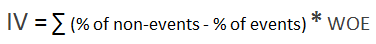

| Information Value | Variable Predictiveness       |
|-------------------|-------------------------------|
| < 0.02            | Not useful for prediction     |
| 0.02 – 0.1        | Weak predictive power         |
| 0.1 – 0.3         | Medium predictive power       |
| 0.3 – 0.5         | Strong predictive power       |
| > 0.5             | Suspicious predictive power   |



In [17]:
def calculate_iv(data: pd.DataFrame, feature: str, target: str):
    crosstab = pd.crosstab(data[feature], data[target], normalize=False)
    crosstab.columns = ['Good', 'Bad']
    crosstab['Total'] = crosstab['Good'] + crosstab['Bad']
    crosstab['Good%'] = crosstab['Good'] / crosstab['Good'].sum()
    crosstab['Bad%'] = crosstab['Bad'] / crosstab['Bad'].sum()
    crosstab = crosstab[(crosstab['Good%'] > 0) & (crosstab['Bad%'] > 0)]
    crosstab['WOE'] = np.log(crosstab['Good%'] / crosstab['Bad%'])
    crosstab['IV'] = (crosstab['Good%'] - crosstab['Bad%']) * crosstab['WOE']
    return crosstab['IV'].sum()

## Card Features

In [ ]:
card_features = [f'card{i}' for i in range(1, 7)]
card_features

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [8]:
# missing value for all card features
for col in card_features:
    missing_count = df[col].isnull().sum()
    missing_pct = df[col].isnull().mean() * 100
    print(f"{col}: Missing Values = {missing_count}, Percentage = {missing_pct:.2f}%")
    

card1: Missing Values = 0, Percentage = 0.00%
card2: Missing Values = 8933, Percentage = 1.51%
card3: Missing Values = 1565, Percentage = 0.27%
card4: Missing Values = 1577, Percentage = 0.27%
card5: Missing Values = 4259, Percentage = 0.72%
card6: Missing Values = 1571, Percentage = 0.27%


- Card1 : user or account ID so it is not null

### Card1

In [9]:
df['card1'].isnull().sum()

np.int64(0)

In [10]:
df['card1'].unique()

array([13926,  2755,  4663, ..., 13166,  8767, 18038], shape=(13553,))

In [11]:
df['card1'].duplicated().sum()

np.int64(576987)

- One account can use for main transaction -> treat this feature like an categorical data

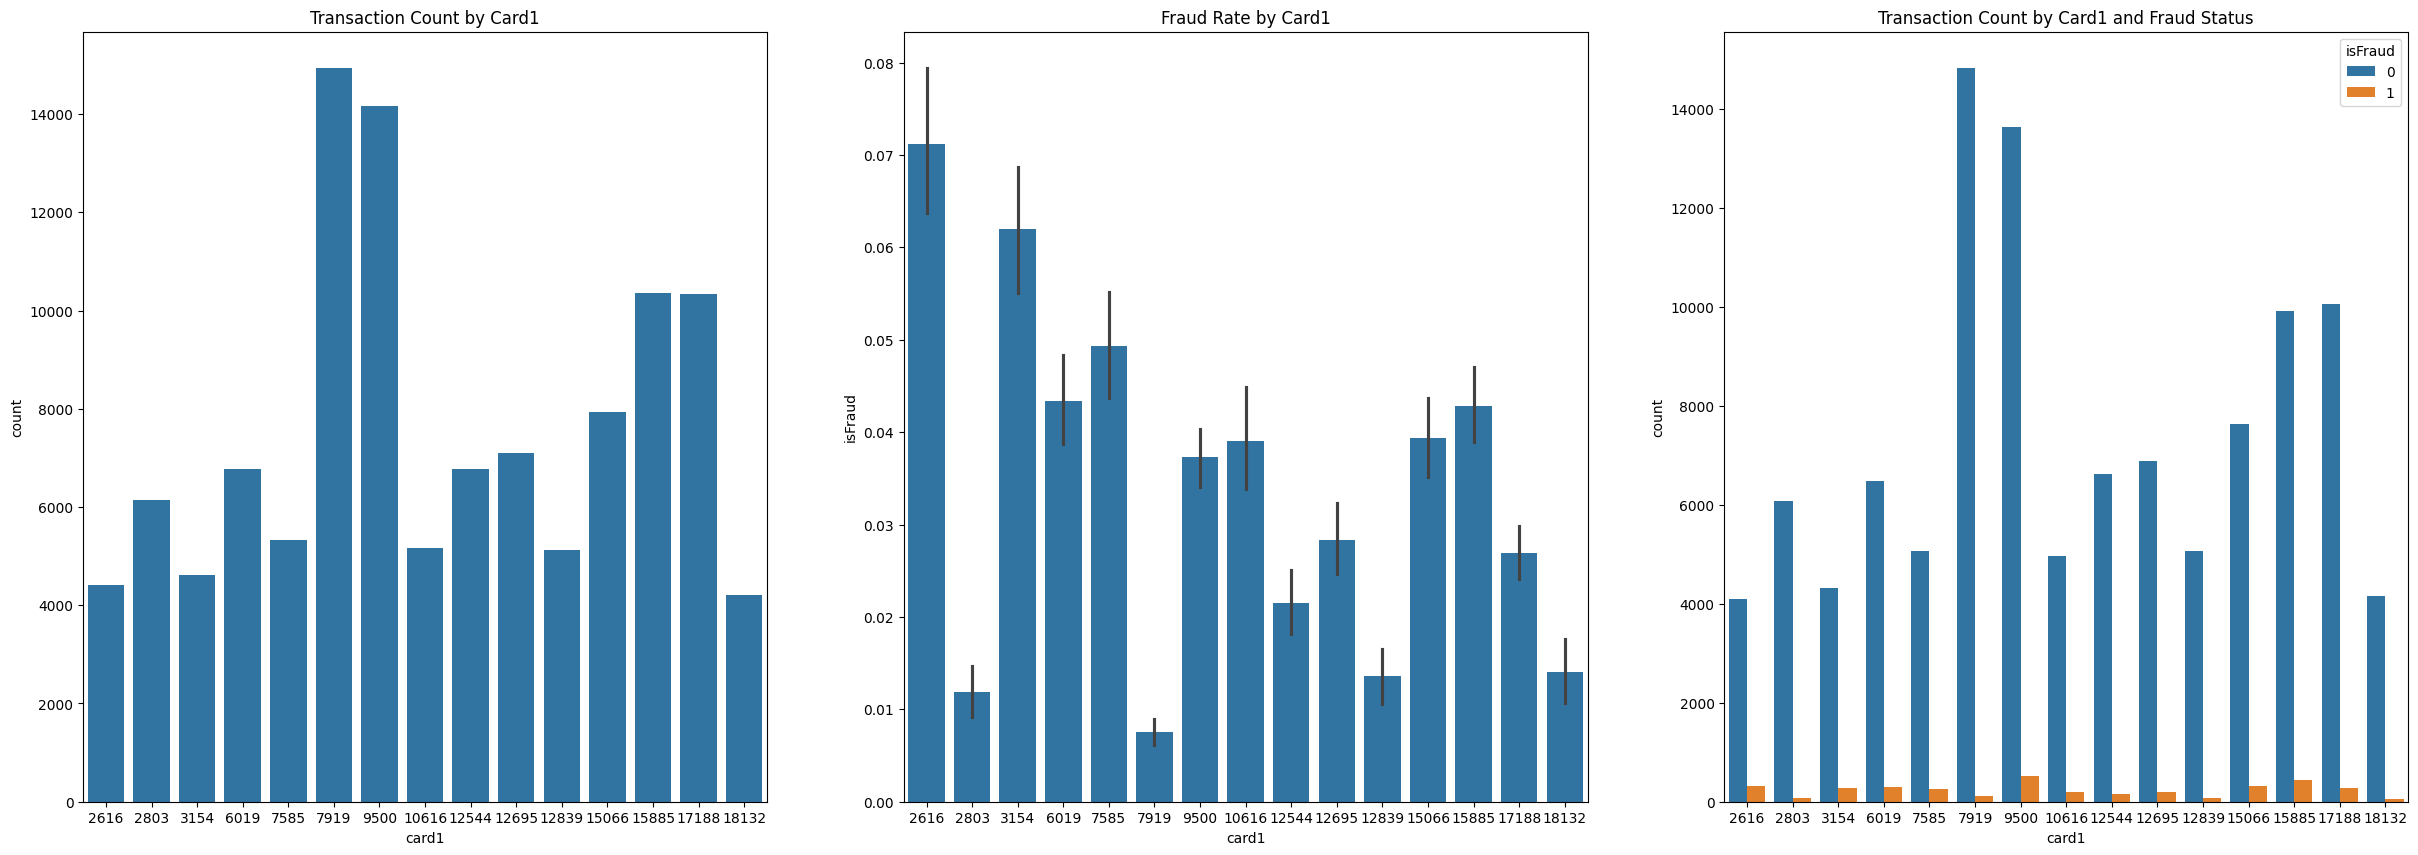

In [3]:
# bar plot of card1 and bar plot of card1 vs fraud rate and bar plot of card1 vs isFraud
# reduce size of feature just keep card feature and fraud feature
# top 20 card1 with most transaction
top_card1 = df['card1'].value_counts().sort_values(ascending=False).head(15).index

fig , axs = plt.subplots(1,3, figsize=(30,10))
sns.countplot(x="card1", data=df[df['card1'].isin(top_card1)], ax=axs[0])
axs[0].set_title("Transaction Count by Card1")
sns.barplot(x="card1", y="isFraud", data=df[df['card1'].isin(top_card1)], ax=axs[1])
axs[1].set_title("Fraud Rate by Card1")
sns.countplot(x="card1", hue="isFraud", data=df[df['card1'].isin(top_card1)], ax=axs[2])
axs[2].set_title("Transaction Count by Card1 and Fraud Status")
plt.show()


After the top 2, the counts drop noticeably, showing a long-tail effect where most card IDs have far fewer transactions. 

7919 and 9500 stand out as extreme outliers with unusually high transaction activity. 

! These IDs could represent high-frequency users, automated transactions, or even anomalies worth deeper investigation (e.g., link to fraud ratio).
 
`Such concentration can bias models: if fraud is concentrated in these high-activity IDs, they will disproportionately influence training.`

`Important next step: check the fraud rate per card1, especially for IDs with extreme transaction volumes.`

In [6]:
df['card1'].unique()

array([13926,  2755,  4663, ..., 13166,  8767, 18038], shape=(13553,))

#### Analyze top 15 user behavior 

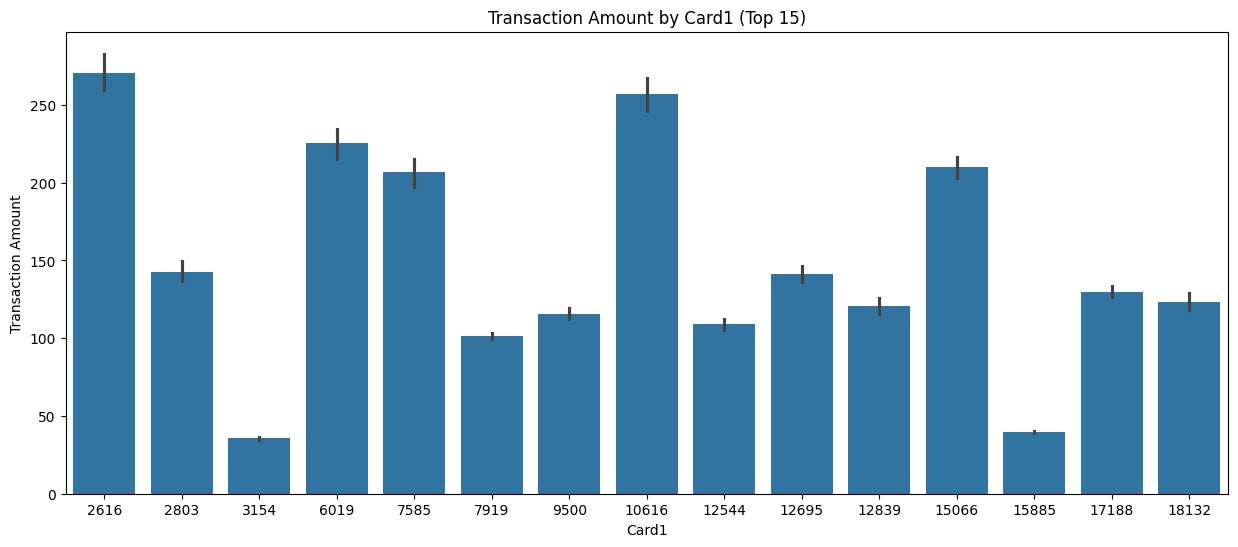

In [6]:
# plot bar chart of TransactionAmt over card1
plt.figure(figsize=(15,6))
sns.barplot(x='card1', y='TransactionAmt', data=df[df['card1'].isin(top_card1)])
plt.title('Transaction Amount by Card1 (Top 15)')
plt.xlabel('Card1')
plt.ylabel('Transaction Amount')
plt.show()


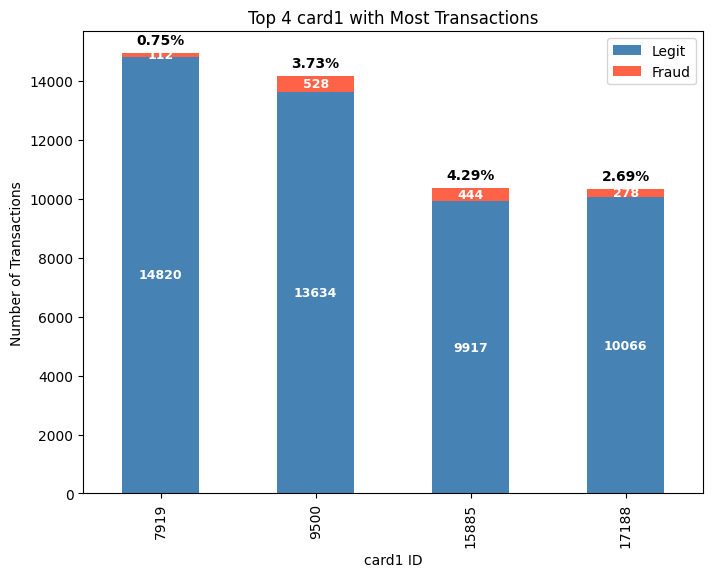

In [7]:
card1_counts = df['card1'].value_counts()

top4_data = df.groupby(['card1', 'isFraud']).size().unstack(fill_value=0).loc[card1_counts.index[:4]]

fraud_ratio = (top4_data[1] / (top4_data[0] + top4_data[1]) * 100).round(2)

ax = top4_data.plot(kind='bar', stacked=True, figsize=(8,6), color=['steelblue','tomato'])

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=9, color='white', fontweight='bold')

for idx, val in enumerate(fraud_ratio):
    total = top4_data.sum(axis=1).iloc[idx]
    ax.text(idx, total + 200, f"{val}%", ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Top 4 card1 with Most Transactions")
plt.xlabel("card1 ID")
plt.ylabel("Number of Transactions")
plt.legend(['Legit', 'Fraud'])
plt.show()


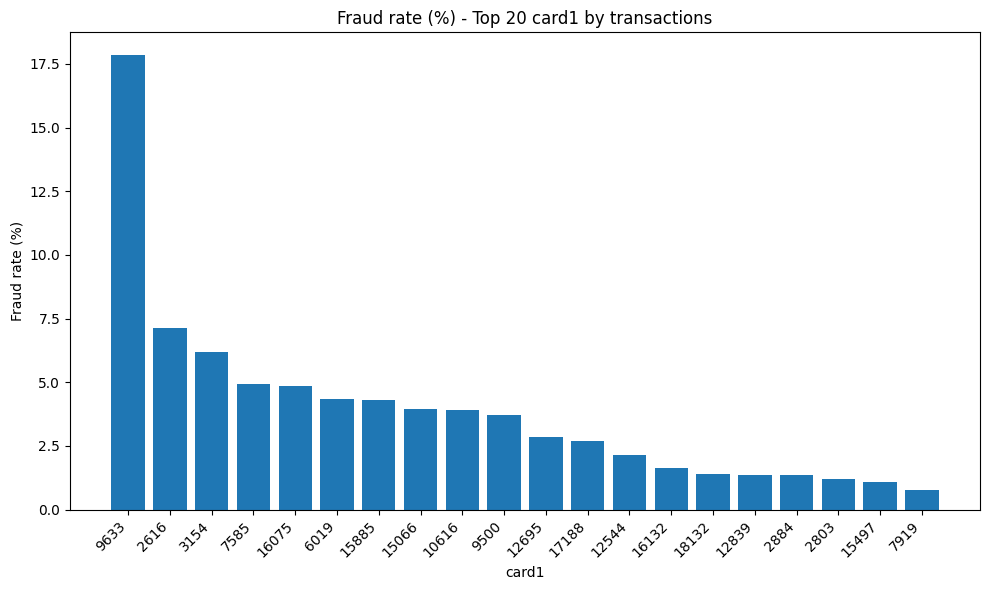

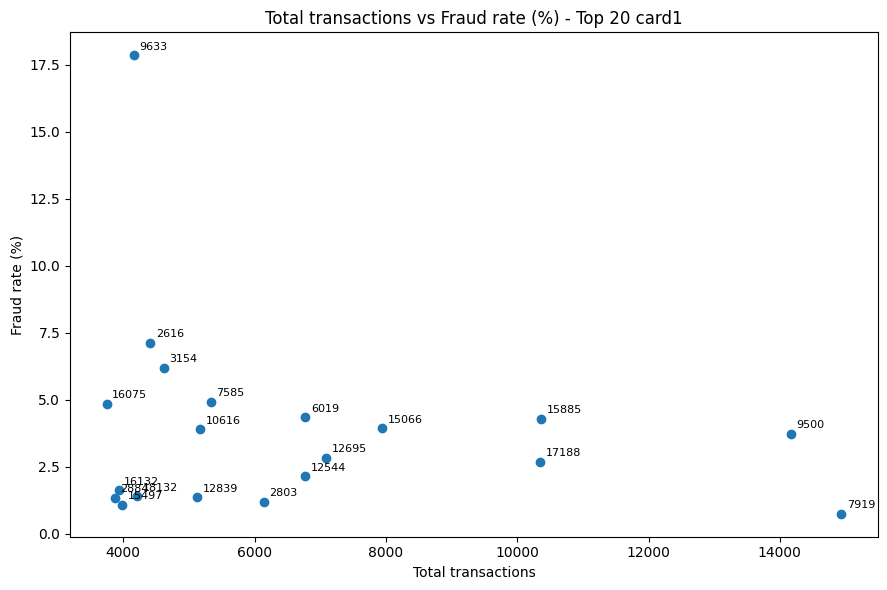

In [8]:
K = 20
topk_ids = df['card1'].value_counts().head(K).index

g = (df[df['card1'].isin(topk_ids)]
     .groupby('card1')['isFraud']
     .agg(total='size', fraud='sum'))
g['fraud_rate'] = g['fraud'] / g['total']

g_bar = g.sort_values('fraud_rate', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(g_bar.index.astype(str), (g_bar['fraud_rate']*100).values)
plt.title(f"Fraud rate (%) - Top {K} card1 by transactions")
plt.xlabel("card1")
plt.ylabel("Fraud rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.scatter(g['total'], g['fraud_rate']*100)
plt.title(f"Total transactions vs Fraud rate (%) - Top {K} card1")
plt.xlabel("Total transactions")
plt.ylabel("Fraud rate (%)")

for rid, row in g.iterrows():
    plt.annotate(str(rid), (row['total'], row['fraud_rate']*100),
                 textcoords="offset points", xytext=(4,4), fontsize=8)
plt.tight_layout()
plt.show()

*Summary* `This feature just like an accountI, may be not have any meaning full in training model -> can drop this column and feature engineering another columns `

### Card 2

In [15]:
# missing value of card2
df['card2'].isnull().sum()


np.int64(8933)

In [16]:
# mark it as -1 stand for unknown
df['card2'].fillna(-1, inplace=True)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\3562924732.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['card2'].fillna(-1, inplace=True)


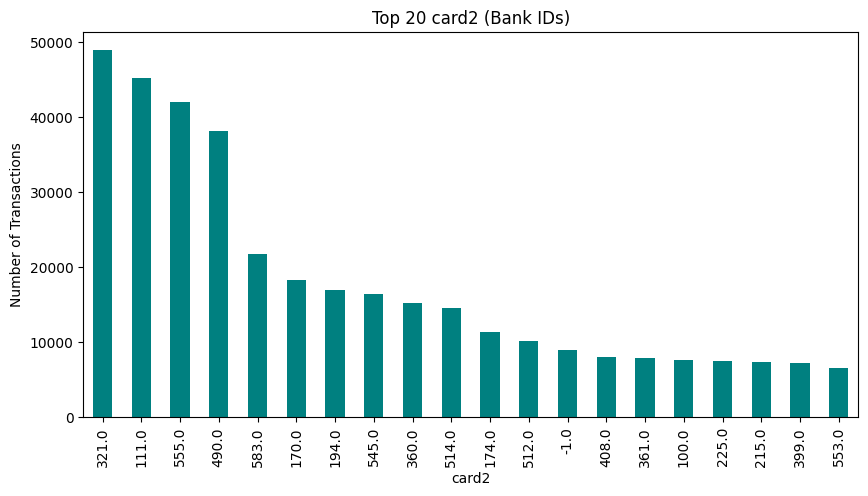

In [17]:
card2_counts = df['card2'].value_counts().head(20)

plt.figure(figsize=(10,5))
card2_counts.plot(kind='bar', color='teal')
plt.title("Top 20 card2 (Bank IDs)")
plt.xlabel("card2")
plt.ylabel("Number of Transactions")
plt.show()

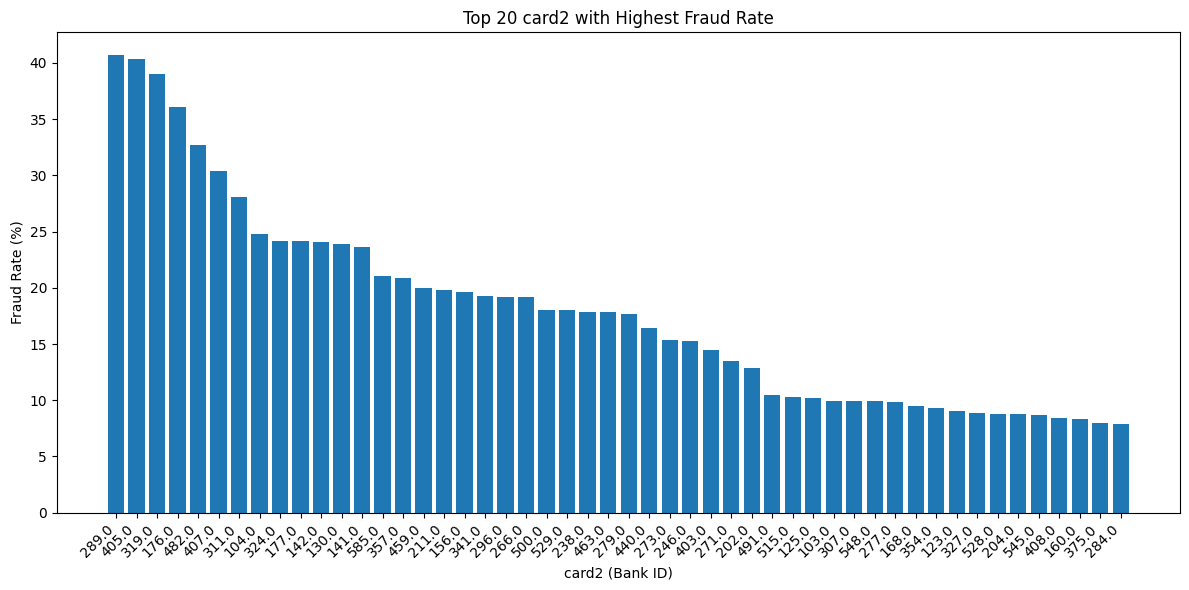

In [18]:
card2_stats = df.groupby('card2')['isFraud'].agg(total='count', fraud='sum')
card2_stats['fraud_rate'] = card2_stats['fraud'] / card2_stats['total']

card2_sorted = card2_stats.sort_values('fraud_rate', ascending=False).head(50)

plt.figure(figsize=(12,6))
plt.bar(card2_sorted.index.astype(str), card2_sorted['fraud_rate']*100)
plt.title("Top 20 card2 with Highest Fraud Rate")
plt.xlabel("card2 (Bank ID)")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


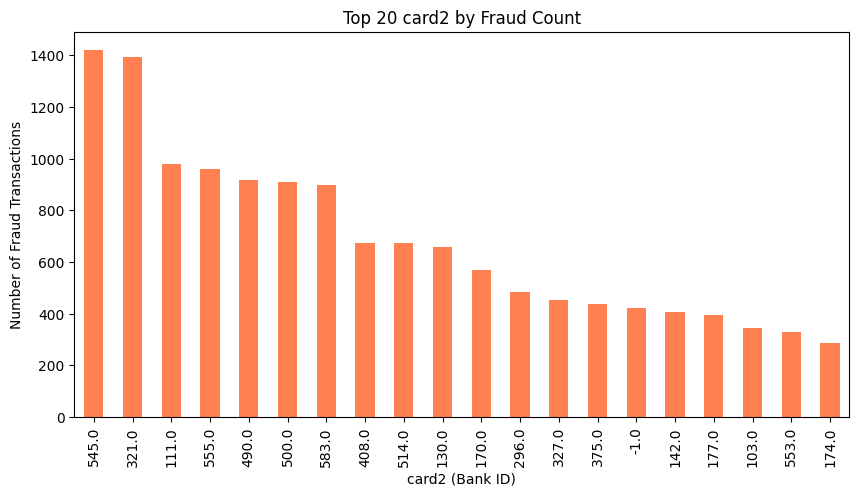

In [19]:
# Top 20 card2 by isFraud count
top20_card2_fraud = df[df['isFraud'] == 1]['card2'].value_counts().head(20)
plt.figure(figsize=(10,5))
top20_card2_fraud.plot(kind='bar', color='coral')
plt.title("Top 20 card2 by Fraud Count")
plt.xlabel("card2 (Bank ID)")
plt.ylabel("Number of Fraud Transactions")
plt.show()


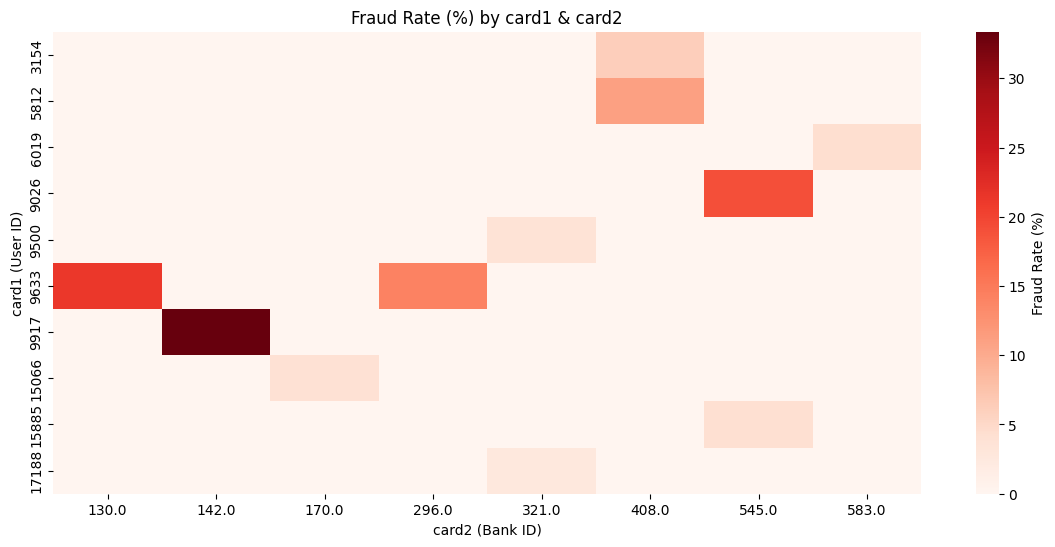

In [13]:
fraud_pairs = (df.groupby(['card1','card2'])['isFraud']
                 .agg(total='count', fraud='sum'))
fraud_pairs['fraud_rate'] = fraud_pairs['fraud'] / fraud_pairs['total']
fraud_pairs = fraud_pairs.reset_index()


# top_pairs = fraud_pairs.sort_values('fraud', ascending=False).head(20)


top_card1 = fraud_pairs.groupby('card1')['fraud'].sum().sort_values(ascending=False).head(10).index
subset = fraud_pairs[fraud_pairs['card1'].isin(top_card1)]

# pivot cho heatmap
pivot = subset.pivot_table(values='fraud_rate', index='card1', columns='card2', fill_value=0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot*100, cmap="Reds", cbar_kws={'label': 'Fraud Rate (%)'})
plt.title("Fraud Rate (%) by card1 & card2")
plt.xlabel("card2 (Bank ID)")
plt.ylabel("card1 (User ID)")
plt.show()

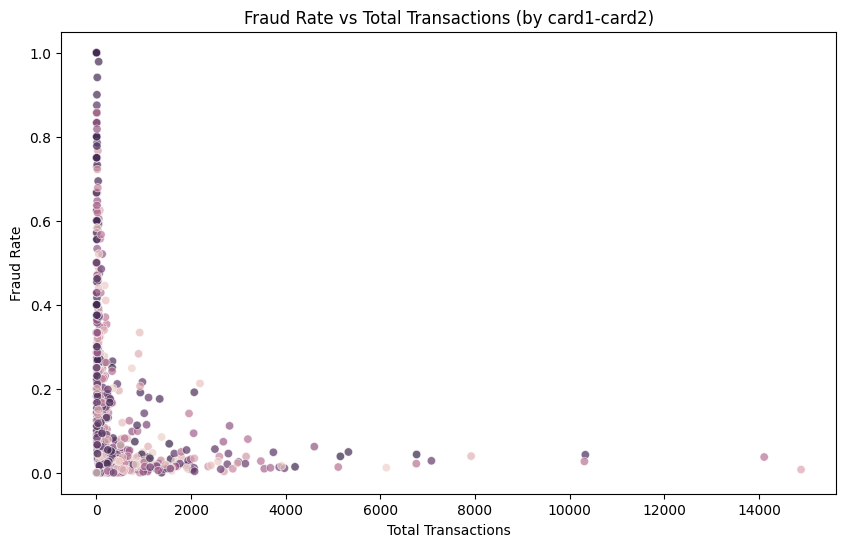

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=fraud_pairs, x='total', y='fraud_rate', hue='card2', alpha=0.7, legend=False)
plt.title("Fraud Rate vs Total Transactions (by card1-card2)")
plt.xlabel("Total Transactions")
plt.ylabel("Fraud Rate")
plt.show()


### Card3 

In [25]:
# missing value of card3 
df['card3'].isnull().sum()

np.int64(0)

In [24]:
# mark it as -1 stand for unknown
df['card3'].fillna(-1, inplace=True)

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\1965686506.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['card3'].fillna(-1, inplace=True)


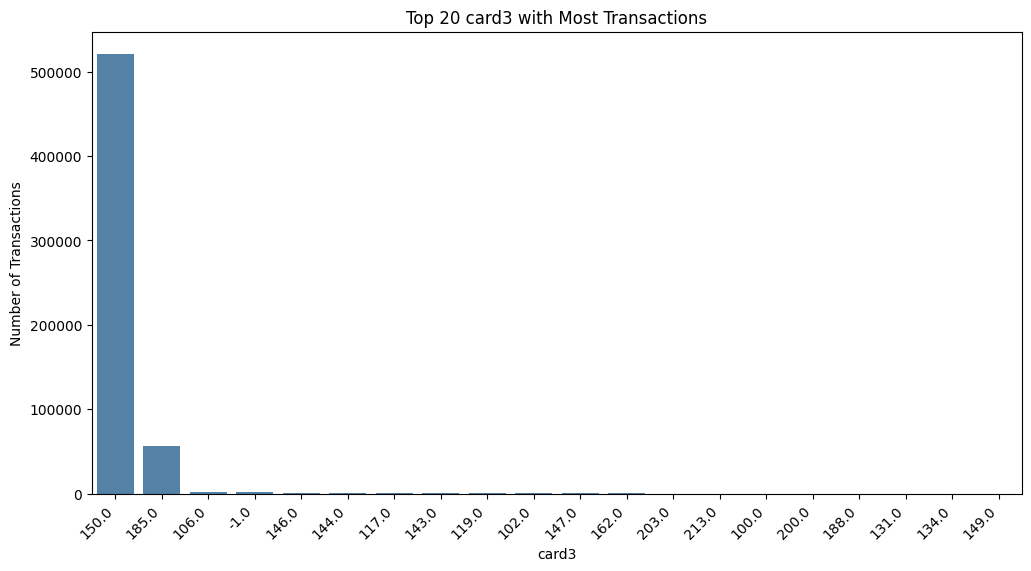

In [26]:
card3_counts = df['card3'].value_counts().head(20) 

plt.figure(figsize=(12,6))
sns.barplot(x=card3_counts.index.astype(str), y=card3_counts.values, color='steelblue')
plt.title("Top 20 card3 with Most Transactions")
plt.xlabel("card3")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45, ha='right')
plt.show()

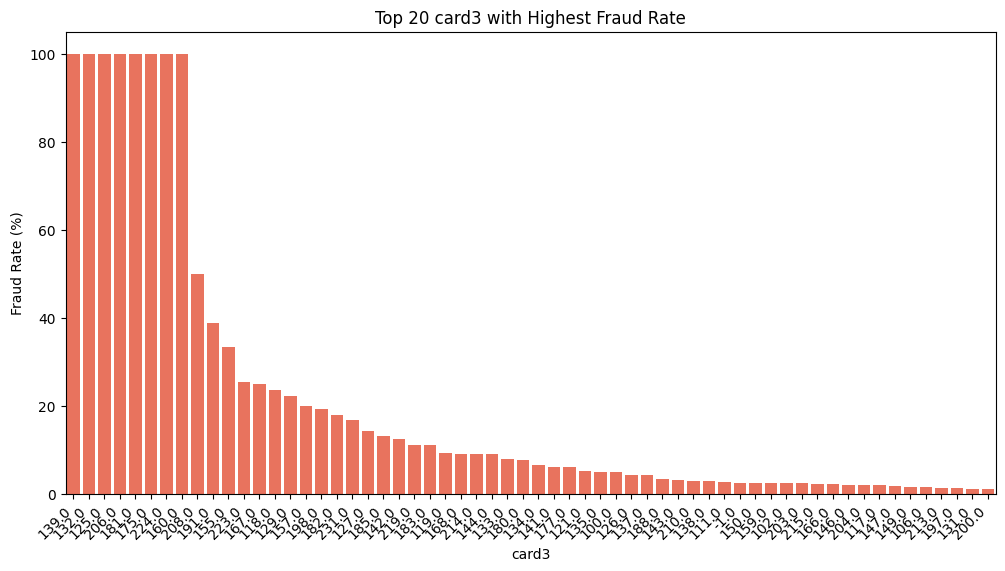

In [27]:
card3_stats = df.groupby('card3')['isFraud'].agg(total='count', fraud='sum')
card3_stats['fraud_rate'] = card3_stats['fraud'] / card3_stats['total']

card3_sorted = card3_stats.sort_values('fraud_rate', ascending=False).head(60)

plt.figure(figsize=(12,6))
sns.barplot(x=card3_sorted.index.astype(str), y=card3_sorted['fraud_rate']*100, color='tomato')
plt.title("Top 20 card3 with Highest Fraud Rate")
plt.xlabel("card3")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.show()

There are many types of card3 that show a 100% fraud rate, but these categories have only a very small number of transactions. This means the high fraud rate is likely due to low sample size rather than a genuine risk pattern, and should be interpreted with caution.

We can bining to reduce this phenomina

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\3445650649.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='card3_binned', y='isFraud', data=df, palette='magma')


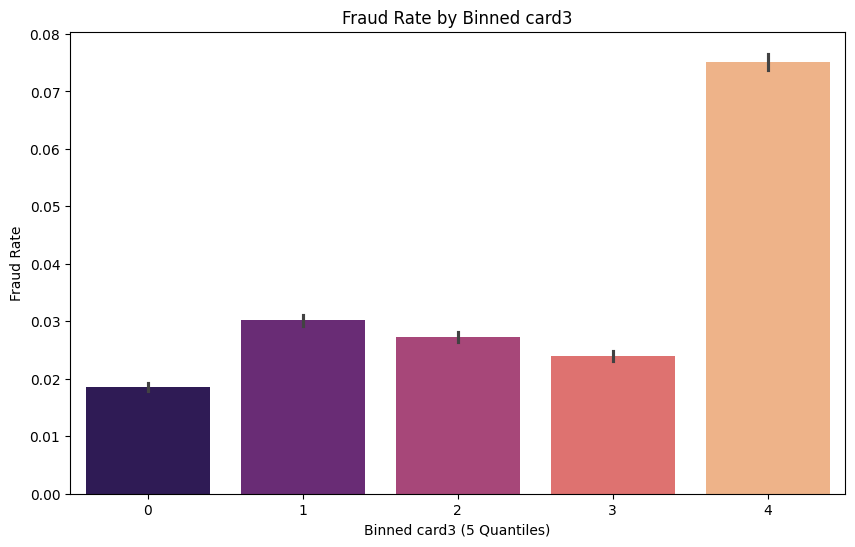

In [28]:
# bining card3 into 5 bins
df['card3_binned'] = pd.qcut(df['card3'].rank(method='first'), q=5, labels=False)
df['card3_binned'].value_counts().sort_index()
# bar plot of card3_binned vs fraud rate
plt.figure(figsize=(10,6))
sns.barplot(x='card3_binned', y='isFraud', data=df, palette='magma')
plt.title('Fraud Rate by Binned card3')
plt.xlabel('Binned card3 (5 Quantiles)')
plt.ylabel('Fraud Rate')
plt.show()


### Card 4

In [30]:
# Fill missing value of card4 with 'unknown'
df['card4'].isnull().sum()
df['card4'].fillna('unknown', inplace=True)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\1704362410.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['card4'].fillna('unknown', inplace=True)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\4162739758.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='card4', data=df, order=df['card4'].value_counts().index, palette="Set2")


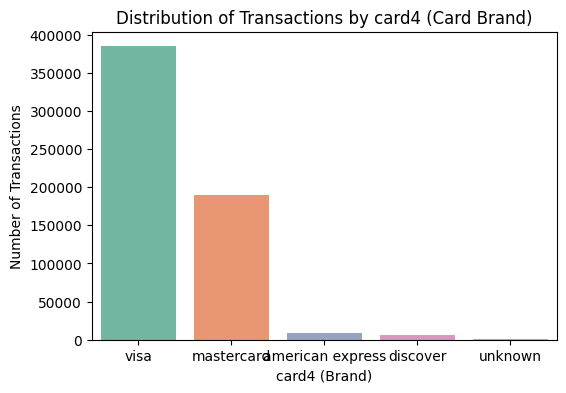

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\4162739758.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=card4_stats.index, y=card4_stats['fraud_rate']*100, palette="Set1")


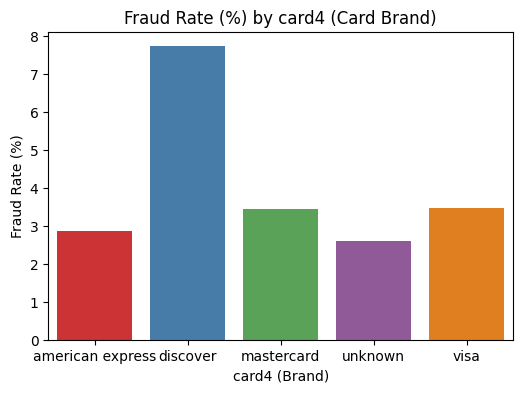

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(x='card4', data=df, order=df['card4'].value_counts().index, palette="Set2")
plt.title("Distribution of Transactions by card4 (Card Brand)")
plt.xlabel("card4 (Brand)")
plt.ylabel("Number of Transactions")
plt.show()


card4_stats = df.groupby('card4')['isFraud'].agg(total='count', fraud='sum')
card4_stats['fraud_rate'] = card4_stats['fraud'] / card4_stats['total']

plt.figure(figsize=(6,4))
sns.barplot(x=card4_stats.index, y=card4_stats['fraud_rate']*100, palette="Set1")
plt.title("Fraud Rate (%) by card4 (Card Brand)")
plt.xlabel("card4 (Brand)")
plt.ylabel("Fraud Rate (%)")
plt.show()

### Card 6

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\3730263129.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='card6', data=df, order=df['card6'].value_counts().index, palette="Set2")


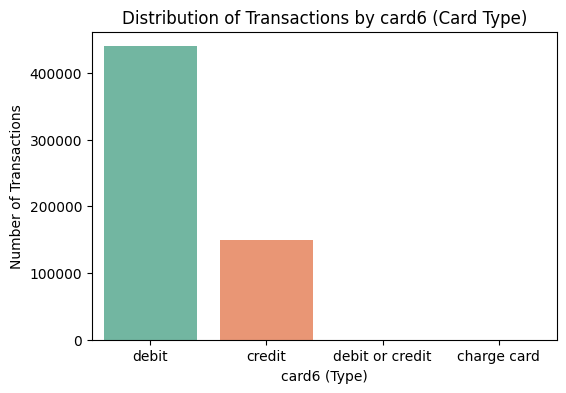

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\3730263129.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=card6_stats.index, y=card6_stats['fraud_rate']*100, palette="Set1")


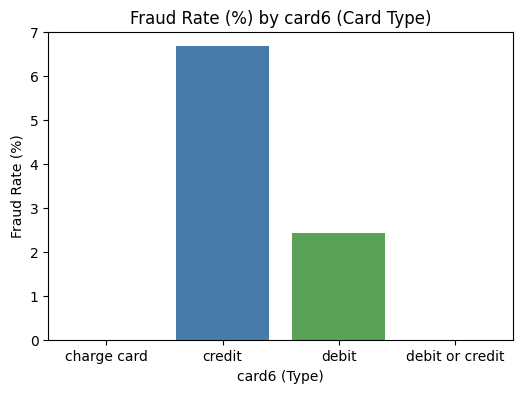

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='card6', data=df, order=df['card6'].value_counts().index, palette="Set2")
plt.title("Distribution of Transactions by card6 (Card Type)")
plt.xlabel("card6 (Type)")
plt.ylabel("Number of Transactions")
plt.show()


card6_stats = df.groupby('card6')['isFraud'].agg(total='count', fraud='sum')
card6_stats['fraud_rate'] = card6_stats['fraud'] / card6_stats['total']

plt.figure(figsize=(6,4))
sns.barplot(x=card6_stats.index, y=card6_stats['fraud_rate']*100, palette="Set1")
plt.title("Fraud Rate (%) by card6 (Card Type)")
plt.xlabel("card6 (Type)")
plt.ylabel("Fraud Rate (%)")
plt.show()



C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\595962758.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='card6_grouped', data=df, order=df['card6_grouped'].value_counts().index, palette="Set2", ax=axs[0])
C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\595962758.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='card6_grouped', y='isFraud', data=df, order=df['card6_grouped'].value_counts().index, palette="Set1", ax=axs[1])


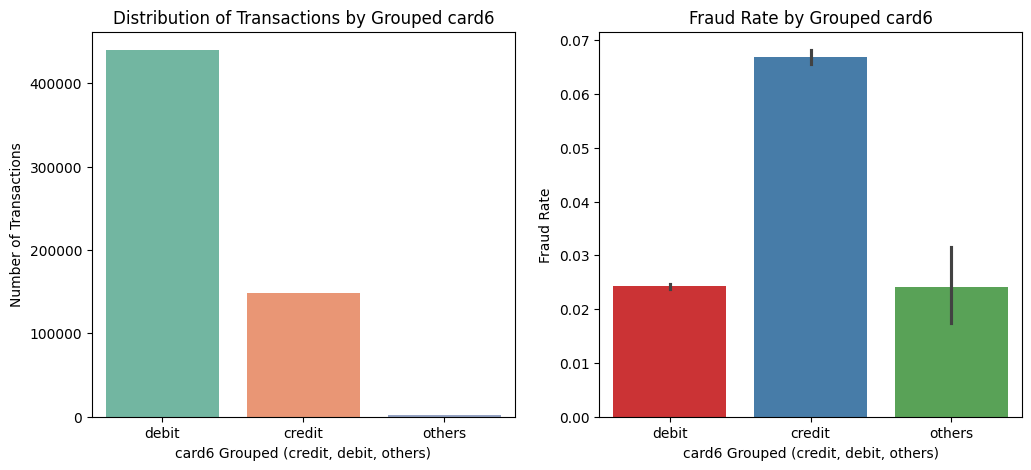

In [37]:
# group card6 into 3 groups: credit, debit and others
def categorize_card_type(card_type):
    if pd.isnull(card_type):
        return "others"
    card_type = card_type.lower()
    if card_type == 'credit':
        return 'credit'
    elif card_type == 'debit':
        return 'debit'
    else:
        return 'others'

df['card6_grouped'] = df['card6'].apply(categorize_card_type)
df['card6_grouped'].value_counts()

fig , axs = plt.subplots(1,2, figsize=(12,5))

# bar plot of card6_grouped vs fraud rate
sns.countplot(x='card6_grouped', data=df, order=df['card6_grouped'].value_counts().index, palette="Set2", ax=axs[0])
axs[0].set_title("Distribution of Transactions by Grouped card6")
axs[0].set_xlabel("card6 Grouped (credit, debit, others)")
axs[0].set_ylabel("Number of Transactions")

# bar plot of card6_grouped vs fraud rate   
sns.barplot(x='card6_grouped', y='isFraud', data=df, order=df['card6_grouped'].value_counts().index, palette="Set1", ax=axs[1])
axs[1].set_title("Fraud Rate by Grouped card6")
axs[1].set_xlabel("card6 Grouped (credit, debit, others)")
axs[1].set_ylabel("Fraud Rate")
plt.show()




### Analyze Card feature with IV value

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13424\232452123.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series.index, y=iv_series.values, palette='coolwarm')


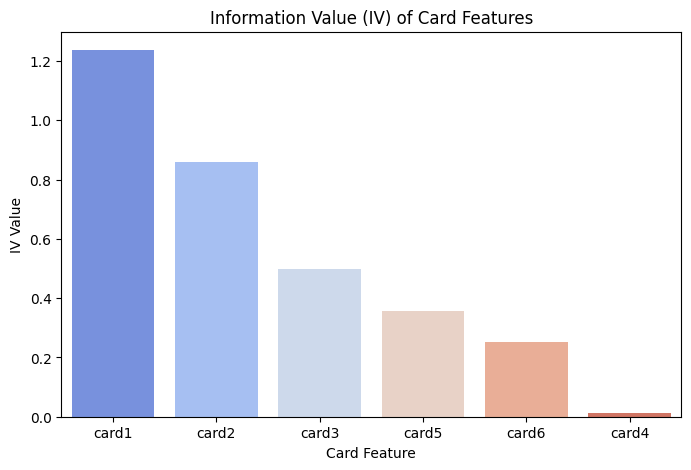

In [41]:
# calculate IV for card features
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
iv_values = {}
for col in card_features:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values[col] = iv
iv_series = pd.Series(iv_values).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=iv_series.index, y=iv_series.values, palette='coolwarm')
plt.title("Information Value (IV) of Card Features")
plt.xlabel("Card Feature")
plt.ylabel("IV Value")
plt.show()


Card 2 adn card 3 are have the Good IV value --> Use this for further analyze

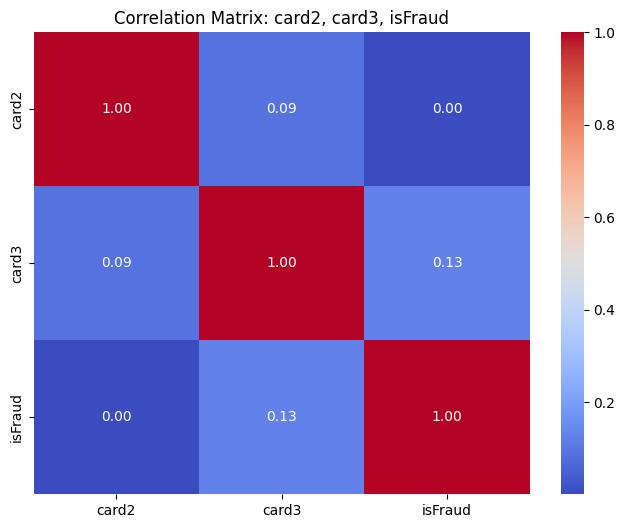

In [42]:
# heat map of correlation between card2 card3 isFraud
plt.figure(figsize=(8,6))
corr = df[['card2', 'card3', 'isFraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: card2, card3, isFraud")
plt.show()


### Use PCA to reduce dimension 

In [45]:
# PCA Analysis for Card Features

# Prepare Card Features data
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# Check which card features exist in the dataframe
available_card_features = [col for col in card_features if col in df.columns]
print("Available card features:", available_card_features)

# Create a copy of card data
card_data = df[available_card_features].copy()

print("\n=== CARD FEATURES PREPROCESSING ===")
print("Original data info:")
for col in available_card_features:
    print(f"{col}: {df[col].dtype}, unique values: {df[col].nunique()}, missing: {df[col].isnull().sum()}")
    
    
# Handle missing values and encode categorical variables
processed_card_data = card_data.copy()

# Fill missing values based on data type
for col in available_card_features:
    if processed_card_data[col].dtype == 'object':
        # For categorical variables, fill with 'unknown'
        processed_card_data[col] = processed_card_data[col].fillna('unknown')
    else:
        # For numerical variables, fill with -1 (already done in your analysis)
        processed_card_data[col] = processed_card_data[col].fillna(-1)

# Encode categorical variables
label_encoders = {}
for col in available_card_features:
    if processed_card_data[col].dtype == 'object':
        le = LabelEncoder()
        processed_card_data[col] = le.fit_transform(processed_card_data[col].astype(str))
        label_encoders[col] = le
    
print("\nAfter preprocessing:")
print(processed_card_data.dtypes)
print("\nProcessed data shape:", processed_card_data.shape)
print("Missing values:", processed_card_data.isnull().sum().sum())


# Standardize the data for PCA
scaler = StandardScaler()
X_card_scaled = scaler.fit_transform(processed_card_data)

print("Standardized data shape:", X_card_scaled.shape)

# Fit PCA
n_components = min(len(available_card_features), 6)  # Use all available features
pca_card = PCA(n_components=n_components)
X_card_pca = pca_card.fit_transform(X_card_scaled)

# Create DataFrame to track contributions
components_card_df = pd.DataFrame(
    pca_card.components_.T,  # Transpose to have features as rows
    columns=[f'PC{i+1}' for i in range(pca_card.n_components_)],
    index=available_card_features
)

print("\n=== PCA ANALYSIS FOR CARD FEATURES ===\n")

# Show explained variance ratio
print("Explained Variance Ratio by Component:")
for i, ratio in enumerate(pca_card.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

cumvar_card = np.cumsum(pca_card.explained_variance_ratio_)
print(f"\nCumulative explained variance:")
print(f"First 2 components: {cumvar_card[1]:.4f} ({cumvar_card[1]*100:.1f}%)")
print(f"First 3 components: {cumvar_card[2]:.4f} ({cumvar_card[2]*100:.1f}%)")

Available card features: ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

=== CARD FEATURES PREPROCESSING ===
Original data info:
card1: int64, unique values: 13553, missing: 0
card2: float64, unique values: 501, missing: 0
card3: float64, unique values: 115, missing: 0
card4: object, unique values: 5, missing: 0
card5: float64, unique values: 119, missing: 4259
card6: object, unique values: 4, missing: 1571

After preprocessing:
card1      int64
card2    float64
card3    float64
card4      int64
card5    float64
card6      int64
dtype: object

Processed data shape: (590540, 6)
Missing values: 0
Standardized data shape: (590540, 6)

=== PCA ANALYSIS FOR CARD FEATURES ===

Explained Variance Ratio by Component:
PC1: 0.2469 (24.69%)
PC2: 0.2108 (21.08%)
PC3: 0.1703 (17.03%)
PC4: 0.1505 (15.05%)
PC5: 0.1232 (12.32%)
PC6: 0.0982 (9.82%)

Cumulative explained variance:
First 2 components: 0.4577 (45.8%)
First 3 components: 0.6280 (62.8%)


In [46]:
# Show top contributing features for each component
print("\n=== TOP CONTRIBUTING CARD FEATURES FOR EACH COMPONENT ===")
for i in range(min(3, pca_card.n_components_)):  # Show first 3 components
    pc_name = f'PC{i+1}'
    print(f"\n{pc_name} (explains {pca_card.explained_variance_ratio_[i]*100:.2f}% variance):")
    
    # Get absolute values and sort
    contributions = components_card_df[pc_name].abs().sort_values(ascending=False)
    
    print("All contributing features:")
    for j, (feature, contribution) in enumerate(contributions.items()):
        original_value = components_card_df.loc[feature, pc_name]  # Get original sign
        print(f"  {j+1}. {feature}: {original_value:+.4f} (|{contribution:.4f}|)")


=== TOP CONTRIBUTING CARD FEATURES FOR EACH COMPONENT ===

PC1 (explains 24.69% variance):
All contributing features:
  1. card4: +0.6337 (|0.6337|)
  2. card5: +0.6104 (|0.6104|)
  3. card6: +0.4363 (|0.4363|)
  4. card3: -0.1828 (|0.1828|)
  5. card1: -0.0338 (|0.0338|)
  6. card2: -0.0318 (|0.0318|)

PC2 (explains 21.08% variance):
All contributing features:
  1. card3: +0.5616 (|0.5616|)
  2. card2: +0.5589 (|0.5589|)
  3. card6: -0.4748 (|0.4748|)
  4. card5: +0.3112 (|0.3112|)
  5. card4: +0.2139 (|0.2139|)
  6. card1: -0.0646 (|0.0646|)

PC3 (explains 17.03% variance):
All contributing features:
  1. card1: +0.9647 (|0.9647|)
  2. card4: +0.1550 (|0.1550|)
  3. card2: +0.1537 (|0.1537|)
  4. card5: -0.1340 (|0.1340|)
  5. card6: +0.0574 (|0.0574|)
  6. card3: +0.0217 (|0.0217|)


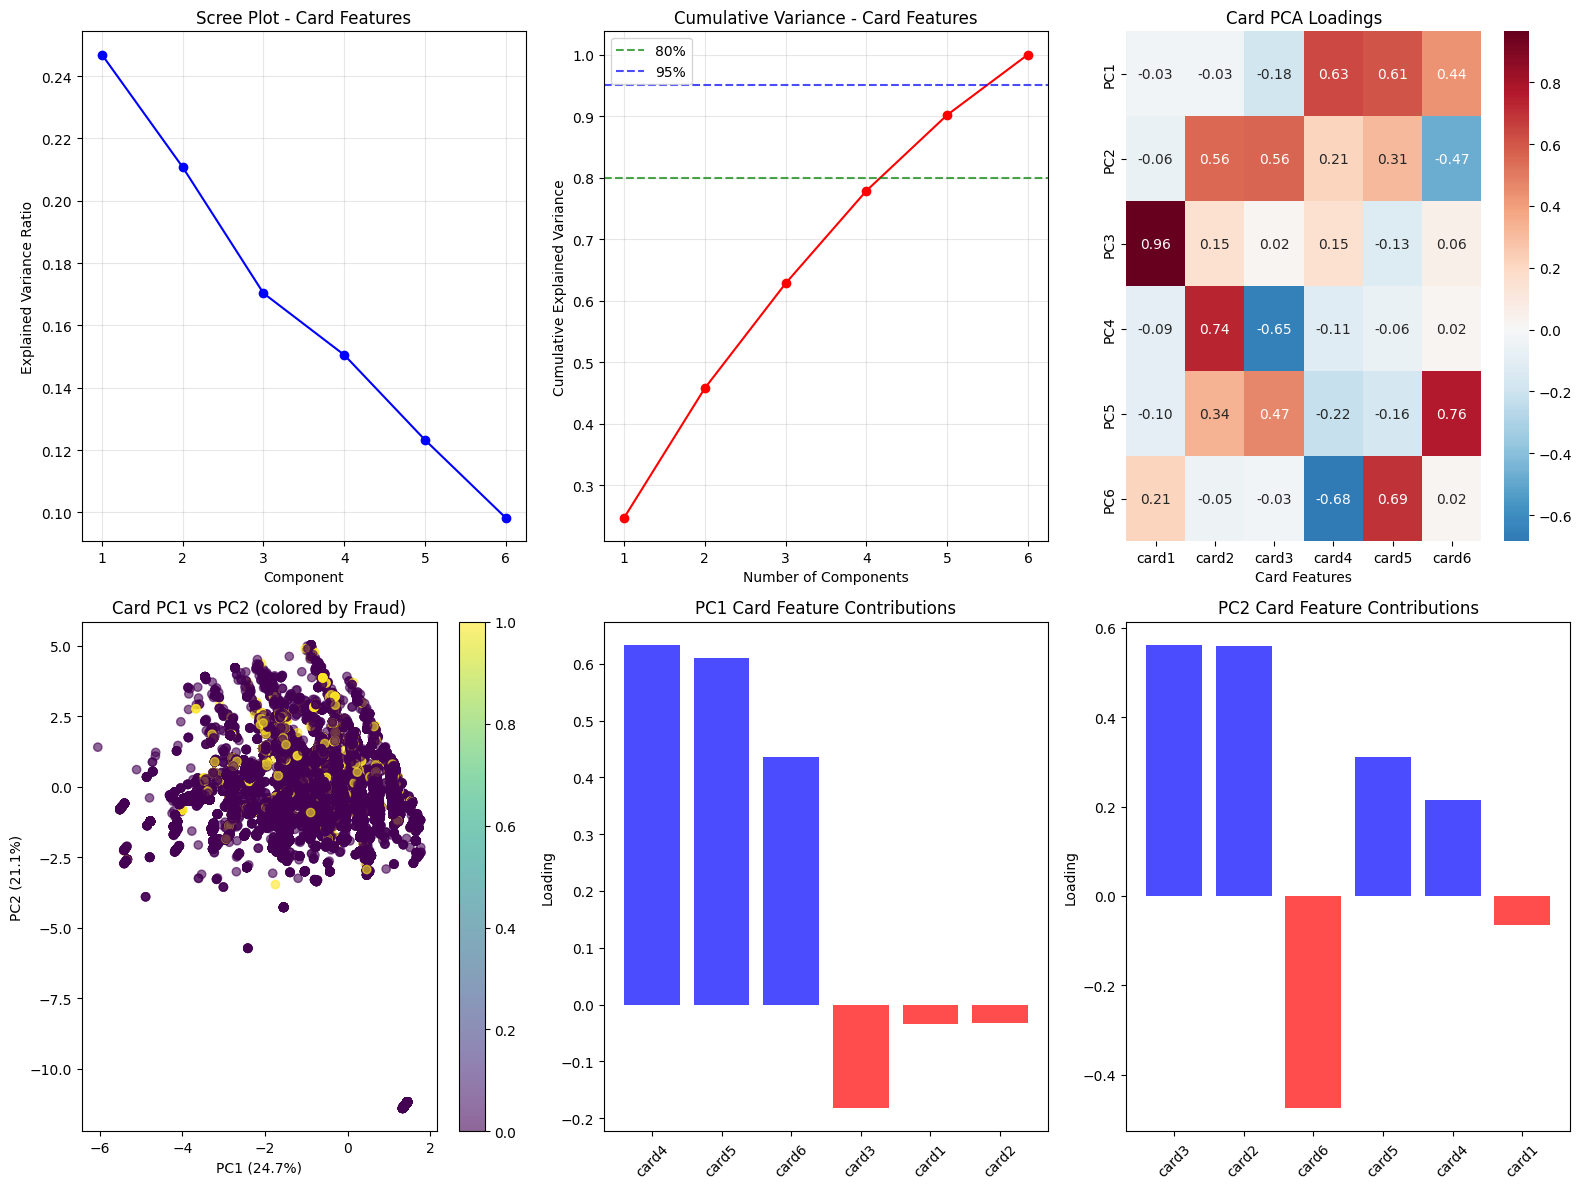

In [47]:
# Visualize Card PCA Results
plt.figure(figsize=(16, 12))

# Plot 1: Scree plot
plt.subplot(2, 3, 1)
plt.plot(range(1, len(pca_card.explained_variance_ratio_)+1), pca_card.explained_variance_ratio_, 'bo-')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Card Features')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative variance
plt.subplot(2, 3, 2)
plt.plot(range(1, len(cumvar_card)+1), cumvar_card, 'ro-')
plt.axhline(y=0.8, color='g', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.95, color='b', linestyle='--', alpha=0.7, label='95%')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance - Card Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Heatmap of loadings
plt.subplot(2, 3, 3)
sns.heatmap(components_card_df.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Card PCA Loadings')
plt.xlabel('Card Features')

# Plot 4: PC1 vs PC2 scatter colored by fraud
plt.subplot(2, 3, 4)
scatter = plt.scatter(X_card_pca[:, 0], X_card_pca[:, 1], c=df['isFraud'], cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca_card.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_card.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Card PC1 vs PC2 (colored by Fraud)')
plt.colorbar(scatter)

# Plot 5: PC1 contributions
plt.subplot(2, 3, 5)
pc1_contrib = components_card_df['PC1'].sort_values(key=abs, ascending=False)
colors = ['red' if x < 0 else 'blue' for x in pc1_contrib]
plt.bar(range(len(pc1_contrib)), pc1_contrib.values, color=colors, alpha=0.7)
plt.xticks(range(len(pc1_contrib)), pc1_contrib.index, rotation=45)
plt.title('PC1 Card Feature Contributions')
plt.ylabel('Loading')

# Plot 6: PC2 contributions  
plt.subplot(2, 3, 6)
if pca_card.n_components_ > 1:
    pc2_contrib = components_card_df['PC2'].sort_values(key=abs, ascending=False)
    colors = ['red' if x < 0 else 'blue' for x in pc2_contrib]
    plt.bar(range(len(pc2_contrib)), pc2_contrib.values, color=colors, alpha=0.7)
    plt.xticks(range(len(pc2_contrib)), pc2_contrib.index, rotation=45)
    plt.title('PC2 Card Feature Contributions')
    plt.ylabel('Loading')

plt.tight_layout()
plt.show()

In [48]:
# Detailed analysis and interpretation
print("\n=== DETAILED CARD FEATURES ANALYSIS ===")

for i in range(min(3, pca_card.n_components_)):
    pc_name = f'PC{i+1}'
    print(f"\n{'-'*60}")
    print(f"{pc_name} - Explains {pca_card.explained_variance_ratio_[i]*100:.2f}% of variance")
    print(f"{'-'*60}")
    
    # All contributions for this component
    contributions = components_card_df[pc_name].sort_values(key=abs, ascending=False)
    
    print("All card feature contributions (sorted by absolute value):")
    for feature, contribution in contributions.items():
        print(f"  {feature}: {contribution:+.4f}")
    
    # Interpretation
    positive_features = contributions[contributions > 0.3].index.tolist()
    negative_features = contributions[contributions < -0.3].index.tolist()
    
    if positive_features:
        print(f"\nStrongly positive features (>0.3): {positive_features}")
    if negative_features:
        print(f"Strongly negative features (<-0.3): {negative_features}")
        
# Add PCA components to dataframe
for i in range(min(3, pca_card.n_components_)):
    df[f'card_PC{i+1}'] = X_card_pca[:, i]

print(f"\n=== CARD FEATURES PCA SUMMARY ===")
print(f"• Original card features: {len(available_card_features)}")
print(f"• PCA components created: {pca_card.n_components_}")
print(f"• First 2 components explain: {cumvar_card[1]*100:.1f}% of variance")
if len(cumvar_card) > 2:
    print(f"• First 3 components explain: {cumvar_card[2]*100:.1f}% of variance")
print(f"• New features added to dataframe: card_PC1, card_PC2, card_PC3")


=== DETAILED CARD FEATURES ANALYSIS ===

------------------------------------------------------------
PC1 - Explains 24.69% of variance
------------------------------------------------------------
All card feature contributions (sorted by absolute value):
  card4: +0.6337
  card5: +0.6104
  card6: +0.4363
  card3: -0.1828
  card1: -0.0338
  card2: -0.0318

Strongly positive features (>0.3): ['card4', 'card5', 'card6']

------------------------------------------------------------
PC2 - Explains 21.08% of variance
------------------------------------------------------------
All card feature contributions (sorted by absolute value):
  card3: +0.5616
  card2: +0.5589
  card6: -0.4748
  card5: +0.3112
  card4: +0.2139
  card1: -0.0646

Strongly positive features (>0.3): ['card3', 'card2', 'card5']
Strongly negative features (<-0.3): ['card6']

------------------------------------------------------------
PC3 - Explains 17.03% of variance
-----------------------------------------------------


=== CARD PCA COMPONENTS vs FRAUD ANALYSIS ===


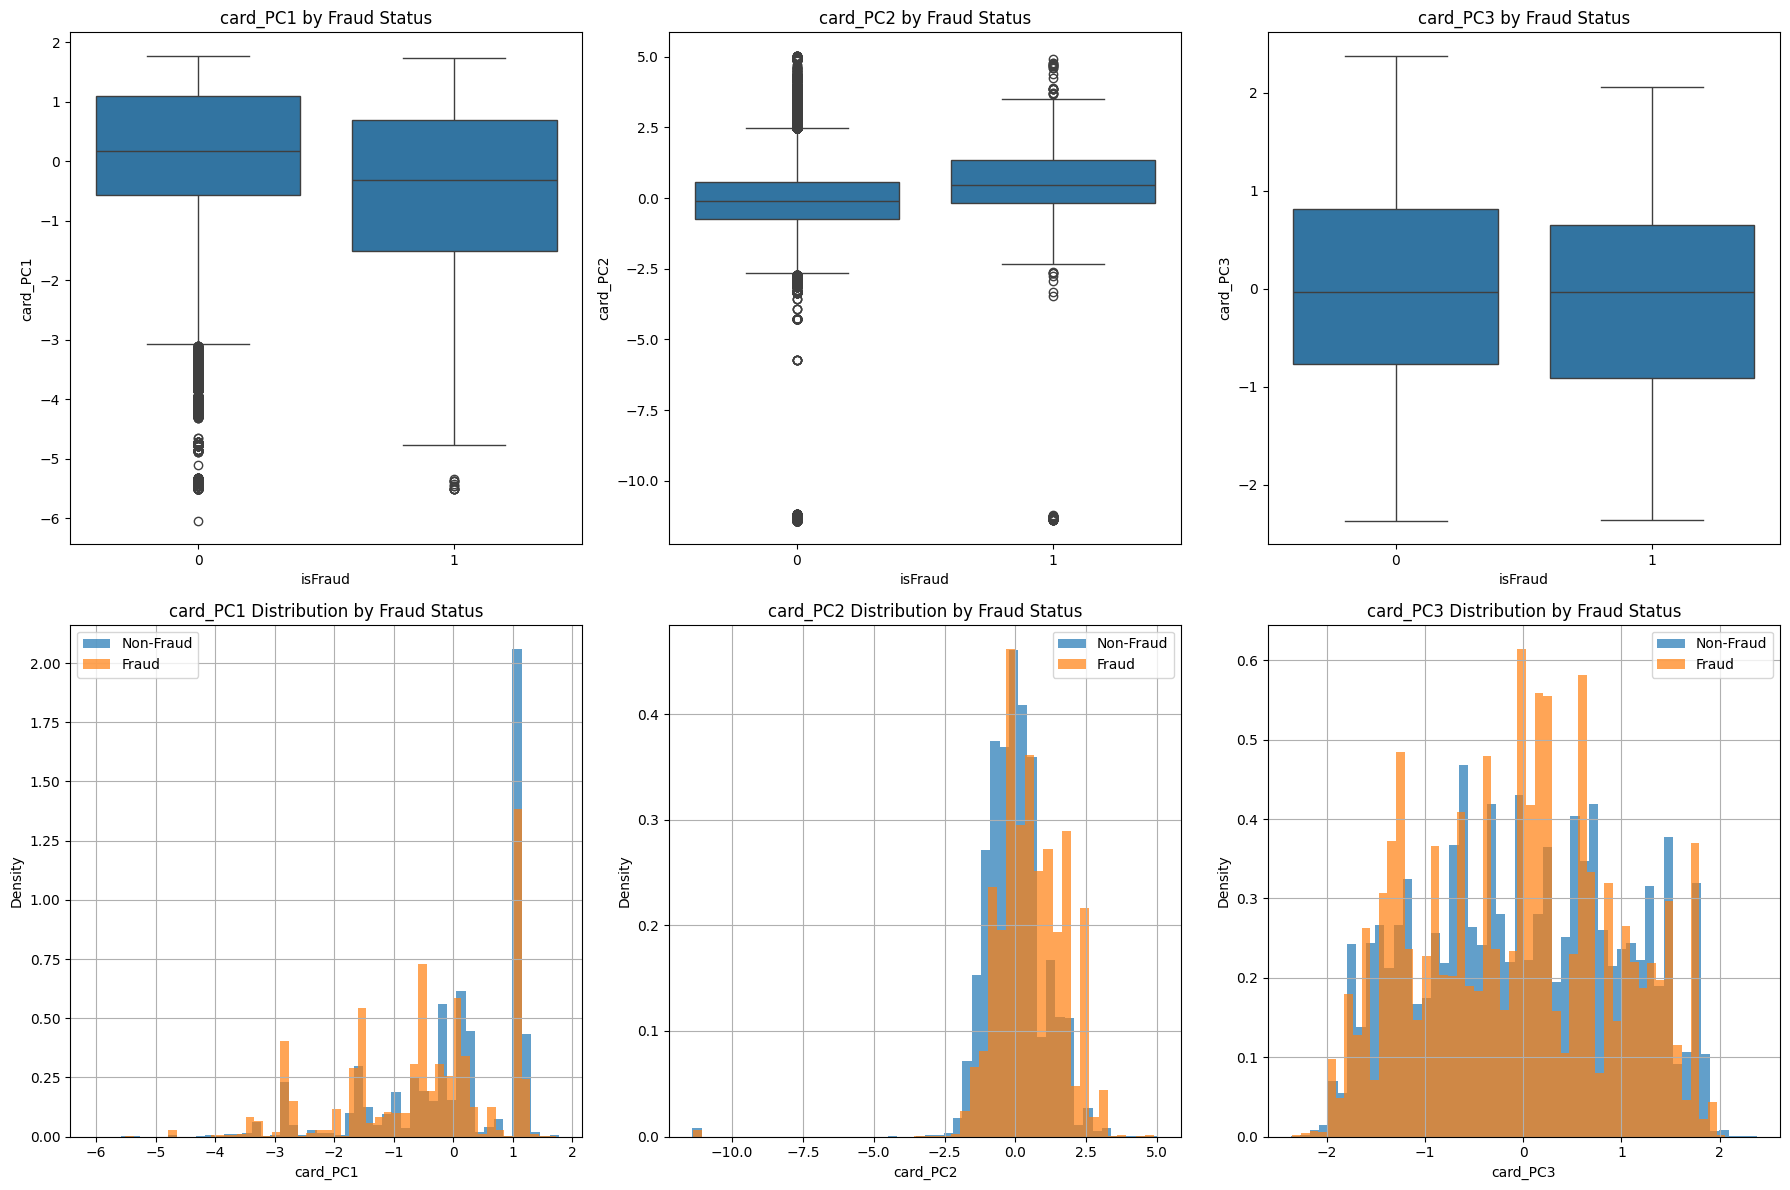


card_PC1 Statistics by Fraud Status:
            count      mean       std       min       25%       50%       75%  \
isFraud                                                                         
0        569877.0  0.016770  1.210516 -6.047937 -0.572330  0.177098  1.098859   
1         20663.0 -0.462499  1.305709 -5.511988 -1.500675 -0.305437  0.689773   

              max  
isFraud            
0        1.779408  
1        1.731109  

card_PC2 Statistics by Fraud Status:
            count      mean       std        min       25%       50%  \
isFraud                                                                
0        569877.0 -0.020658  1.115816 -11.410513 -0.737265 -0.117749   
1         20663.0  0.569744  1.212410 -11.390823 -0.184121  0.460536   

              75%       max  
isFraud                      
0        0.549657  5.033354  
1        1.347333  4.899590  

card_PC3 Statistics by Fraud Status:
            count      mean       std       min       25%       50%     

In [49]:
# Analyze relationship between Card PCA components and Fraud
print("\n=== CARD PCA COMPONENTS vs FRAUD ANALYSIS ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution of each PC by fraud status
for i in range(min(3, pca_card.n_components_)):
    pc_col = f'card_PC{i+1}'
    
    # Box plot
    ax1 = axes[0, i]
    sns.boxplot(data=df, x='isFraud', y=pc_col, ax=ax1)
    ax1.set_title(f'{pc_col} by Fraud Status')
    
    # Density plot
    ax2 = axes[1, i]
    df[df['isFraud']==0][pc_col].hist(bins=50, alpha=0.7, label='Non-Fraud', density=True, ax=ax2)
    df[df['isFraud']==1][pc_col].hist(bins=50, alpha=0.7, label='Fraud', density=True, ax=ax2)
    ax2.set_xlabel(pc_col)
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.set_title(f'{pc_col} Distribution by Fraud Status')

plt.tight_layout()
plt.show()

# Statistical summary
for i in range(min(3, pca_card.n_components_)):
    pc_col = f'card_PC{i+1}'
    print(f"\n{pc_col} Statistics by Fraud Status:")
    print(df.groupby('isFraud')[pc_col].describe())

## Counting Feature

In [4]:
# Missing value of counting feature

for col in df.columns:
    if 'C' in col:
        missing_count = df[col].isnull().sum()
        missing_pct = df[col].isnull().mean() * 100
        print(f"{col}: Missing Values = {missing_count}, Percentage = {missing_pct:.2f}%")

ProductCD: Missing Values = 0, Percentage = 0.00%
C1: Missing Values = 0, Percentage = 0.00%
C2: Missing Values = 0, Percentage = 0.00%
C3: Missing Values = 0, Percentage = 0.00%
C4: Missing Values = 0, Percentage = 0.00%
C5: Missing Values = 0, Percentage = 0.00%
C6: Missing Values = 0, Percentage = 0.00%
C7: Missing Values = 0, Percentage = 0.00%
C8: Missing Values = 0, Percentage = 0.00%
C9: Missing Values = 0, Percentage = 0.00%
C10: Missing Values = 0, Percentage = 0.00%
C11: Missing Values = 0, Percentage = 0.00%
C12: Missing Values = 0, Percentage = 0.00%
C13: Missing Values = 0, Percentage = 0.00%
C14: Missing Values = 0, Percentage = 0.00%


In [5]:
# sample value of counting feature
df[[f'C{i}' for i in range(1, 15)]].head(10)


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
6,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
7,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
9,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0


In [9]:
counting_df = df[[f'C{i}' for i in range(1, 15)] + ['isFraud']].copy()


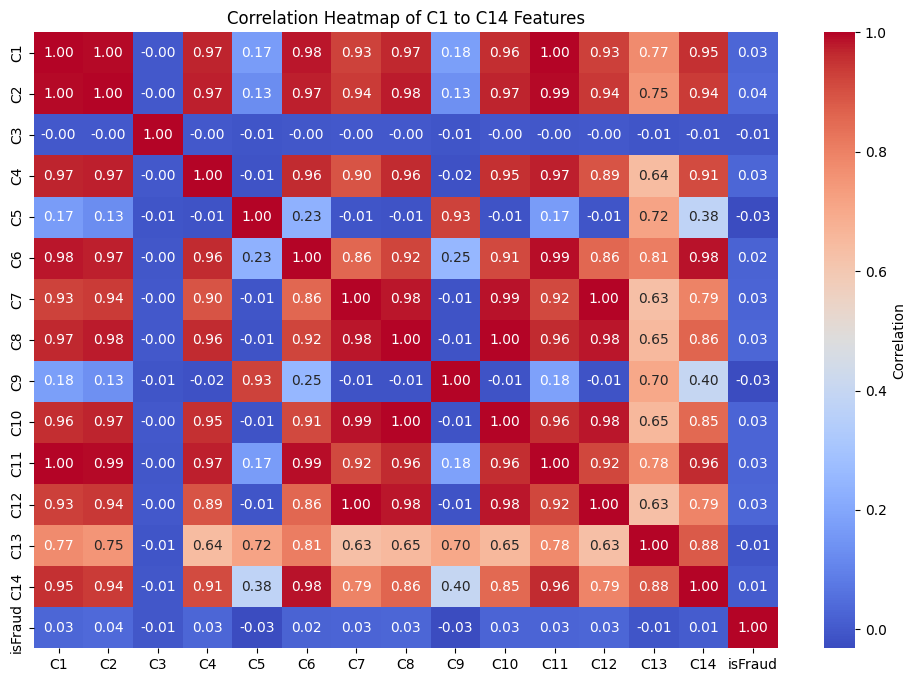

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(counting_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of C1 to C14 Features")
plt.show()

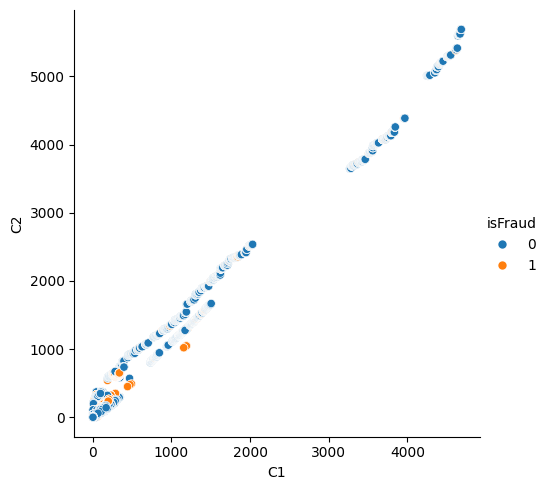

In [11]:
sns.relplot(data= counting_df , x= 'C1' , y= 'C2' ,hue= 'isFraud') 

In [13]:
counting_df['C1'].unique()

array([1.000e+00, 2.000e+00, 4.000e+00, ..., 1.494e+03, 1.495e+03,
       1.500e+03], shape=(1657,))

In [14]:
counting_df['C2'].unique()

array([1.000e+00, 5.000e+00, 2.000e+00, ..., 1.657e+03, 1.658e+03,
       1.670e+03], shape=(1216,))

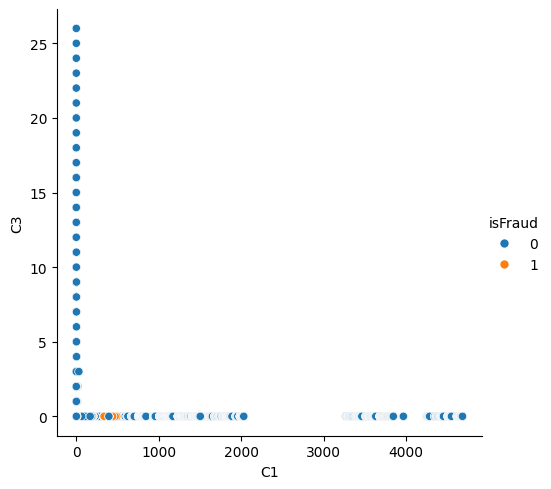

In [15]:
sns.relplot(data= counting_df , x= 'C1' , y= 'C3' ,hue= 'isFraud') 

C:\Users\LEGION\AppData\Local\Temp\ipykernel_5744\2144848363.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series_counting.index, y=iv_series_counting.values, palette='coolwarm')


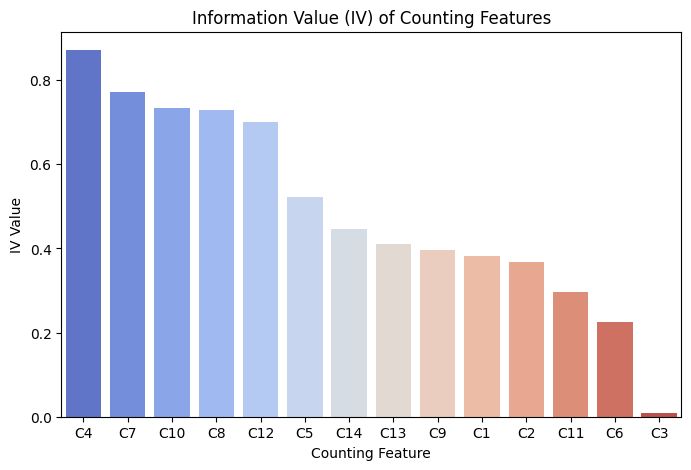

In [18]:
# calculate IV value for counting feature
counting_features = [f'C{i}' for i in range(1, 15)]
iv_values_counting = {}
for col in counting_features:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_counting[col] = iv
iv_series_counting = pd.Series(iv_values_counting).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=iv_series_counting.index, y=iv_series_counting.values, palette='coolwarm')
plt.title("Information Value (IV) of Counting Features")
plt.xlabel("Counting Feature")
plt.ylabel("IV Value")
plt.show()


In [19]:
# filter C features with IV > 0.3 and IV < 0.5 
selected_counting_features = iv_series_counting[(iv_series_counting > 0.3) & (iv_series_counting < 0.5)].index.tolist()
selected_counting_features


['C14', 'C13', 'C9', 'C1', 'C2']

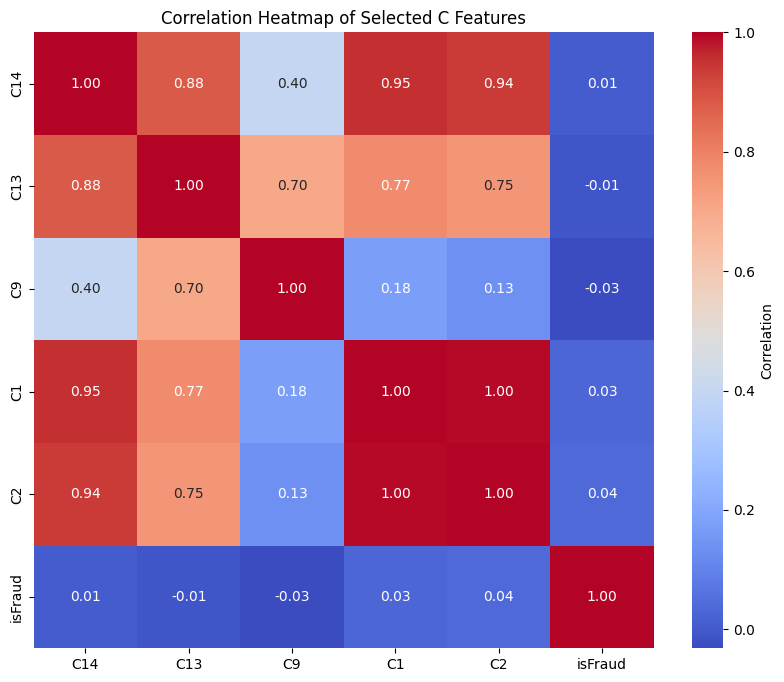

In [20]:
# Correlation heatmap of selected counting features
plt.figure(figsize=(10,8))
sns.heatmap(counting_df[selected_counting_features + ['isFraud']].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of Selected C Features")
plt.show()


In [ ]:

# plot pairplot of selected counting features
sns.pairplot(counting_df[selected_counting_features + ['isFraud']], hue='isFraud', diag_kind='kde', palette={0: 'blue', 1: 'red'}) 


## Time Delta Features

In [ ]:
time_delta_df =  df[[f'D{i}' for i in range(1, 16)]]